# 2487 Machine Learning Assignment 4
#Inside Out
![](https://upload.wikimedia.org/wikipedia/en/0/0a/Inside_Out_%282015_film%29_poster.jpg)




Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise.

Your task is to use deep learning techniques to classify the Tweets into the corresponding emotions:

In [1]:
#!pip install datasets transformers

In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
import re
import string
import numpy as np
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import json
import os
import cohere

np.random.seed(42)
tf.random.set_seed(42)

2024-05-18 23:31:44.969051: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 23:31:47.564306: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
emotion = load_dataset("dair-ai/emotion")

/home/martim_esteves1/.local/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Data Fields

The data fields are:

- text: a string feature.
- label: a classification label, with possible values including sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).

In [4]:
emotion['train'][0]['text'],emotion['train'][0]['label'],emotion['train'].features

('i didnt feel humiliated',
 0,
 {'text': Value(dtype='string', id=None),
  'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)})

In [5]:
emotion['validation'][0]['text'],emotion['validation'][0]['label']

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [6]:
emotion['test'][0]['text'],emotion['test'][0]['label']

('im feeling rather rotten so im not very ambitious right now', 0)

split: with a total of 20_000 examples split into train, validation and split

In [7]:
emotion['train'].shape, emotion['validation'].shape, emotion['test'].shape

((16000, 2), (2000, 2), (2000, 2))

## Question 1 (40 points)
Check the distribution of the text length in the data, build the simple RNN model and LSTM model with one layer, and two stacked layers, respectively and compare their performance. You may choose to pad or truncate the input sequence to be the number closest to 128, 256, 512, etc. You could train at most for 10 epochs if you find it takes much time.

---
### Distribution of the text length in the data

In [8]:
df_train = pd.DataFrame(emotion['train'])
print(60 * '*' + '\nTrain:')
display(df_train)
df_val = pd.DataFrame(emotion['validation'])
print(60 * '*' + '\nValidation:')
display(df_val)
df_test = pd.DataFrame(emotion['test'])
print(60 * '*' + '\nTest:')
display(df_test)

************************************************************
Train:


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


************************************************************
Validation:


,text,label
0,im feeling quite sad and sorry for myself but ...,0
1,i feel like i am still looking at a blank canv...,0
2,i feel like a faithful servant,2
3,i am just feeling cranky and blue,3
4,i can have for a treat or if i am feeling festive,1
...,...,...
1995,im having ssa examination tomorrow in the morn...,0
1996,i constantly worry about their fight against n...,1
1997,i feel its important to share this info for th...,1
1998,i truly feel that if you are passionate enough...,1


************************************************************
Test:


,text,label
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,1
4,i was feeling a little vain when i did this one,0
...,...,...
1995,i just keep feeling like someone is being unki...,3
1996,im feeling a little cranky negative after this...,3
1997,i feel that i am useful to my people and that ...,1
1998,im feeling more comfortable with derby i feel ...,1


In [9]:
df_train['length'] = df_train['text'].apply(lambda x: len(x.split()))
df_val['length'] = df_val['text'].apply(lambda x: len(x.split()))
df_test['length'] = df_test['text'].apply(lambda x: len(x.split()))
display(df_train)

,text,label,length
0,i didnt feel humiliated,0,4
1,i can go from feeling so hopeless to so damned...,0,21
2,im grabbing a minute to post i feel greedy wrong,3,10
3,i am ever feeling nostalgic about the fireplac...,2,18
4,i am feeling grouchy,3,4
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,24
15996,i am now turning and i feel pathetic that i am...,0,20
15997,i feel strong and good overall,1,6
15998,i feel like this was such a rude comment and i...,3,14


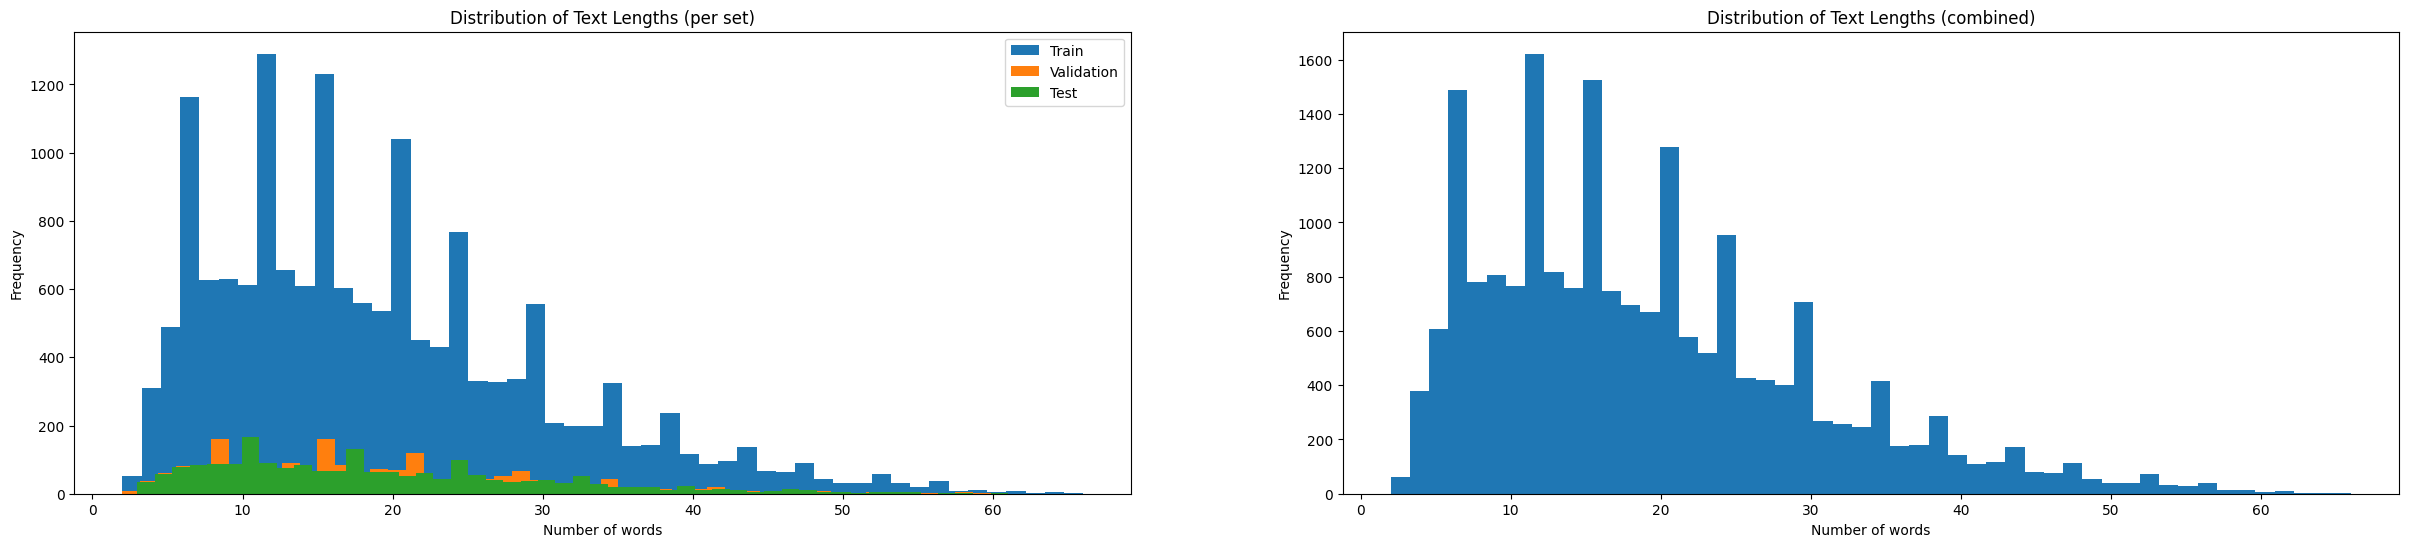

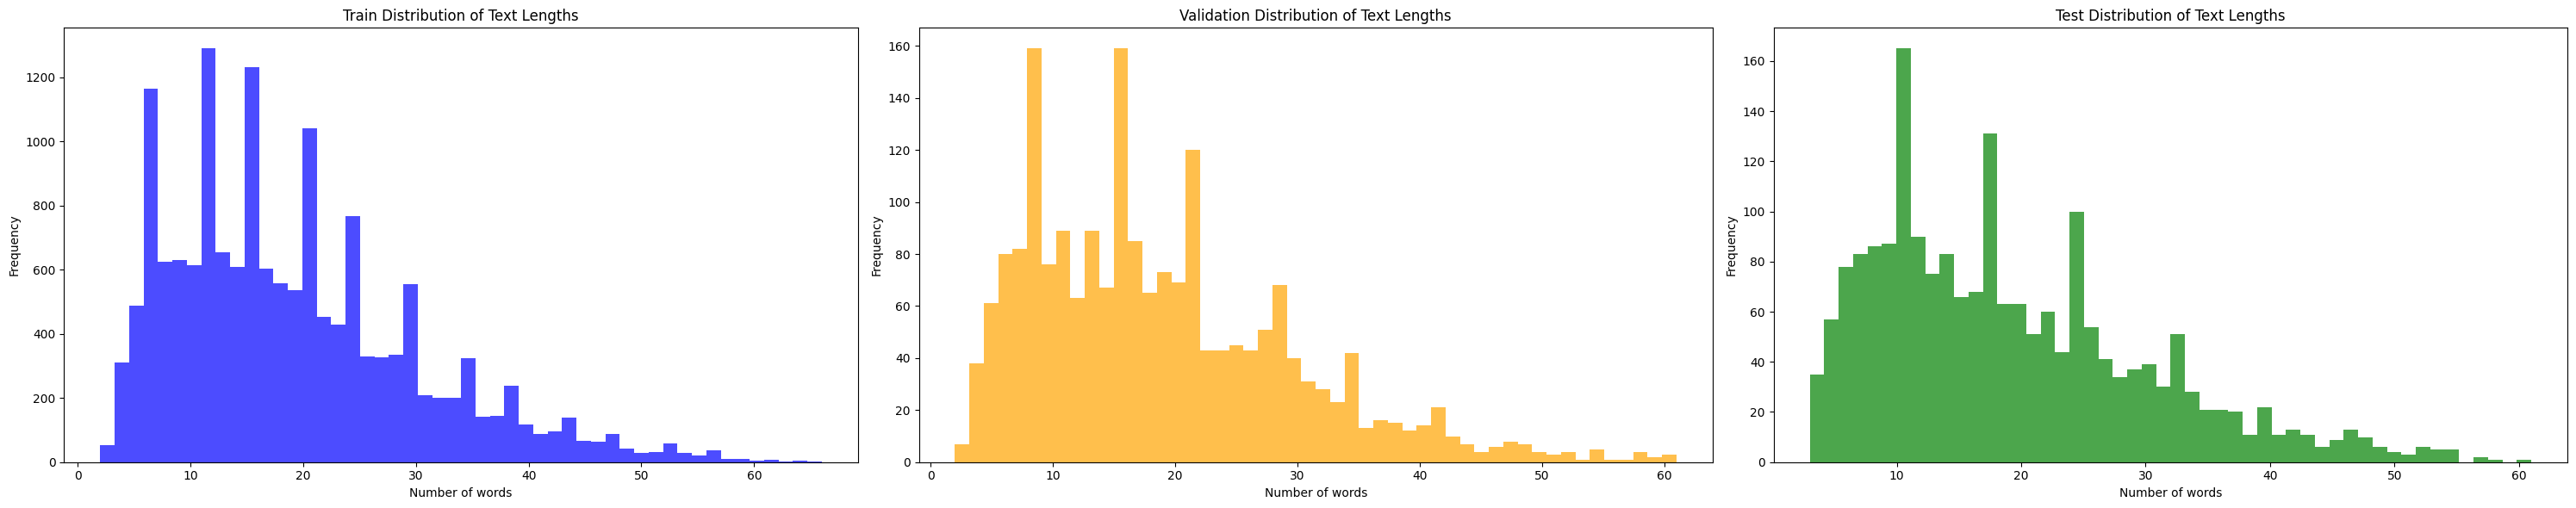

In [10]:
plt.figure(figsize=(30, 6))
plt.subplot(1, 2, 1)

plt.hist(df_train['length'], bins=50, label='Train')
plt.hist(df_val['length'], bins=50, label='Validation')
plt.hist(df_test['length'], bins=50, label='Test')
plt.title('Distribution of Text Lengths (per set)')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
df_joined = pd.concat([df_train, df_val, df_test])
plt.hist(df_joined['length'], bins=50, label='Train')
plt.title('Distribution of Text Lengths (combined)')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(30, 6))
plt.subplot(1, 3, 1)

plt.hist(df_train['length'], bins=50, alpha=0.7, color='blue')
plt.title('Train Distribution of Text Lengths')
plt.xlabel('Number of words')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df_val['length'], bins=50, alpha=0.7, color='orange')
plt.title('Validation Distribution of Text Lengths')
plt.xlabel('Number of words')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(df_test['length'], bins=50, alpha=0.7, color='green')
plt.title('Test Distribution of Text Lengths')
plt.xlabel('Number of words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The text is skewed to the right, which makes sense, since tweets are typically short messages, but there are some rare outliers that are very long.

---
### Text Preprocessing

Even though the question suggested a min lenght of 128, this does not suit the data that has at most arround 60 words. We will instead use 50, as it retains most of the sequences perfectly, while truncating the few tweets that are longer than normal. We want to avoid truncating as much as possible, since the tweets are short and we would lose a lot of information, but at the same time too much training would increase the computational cost and potentially overfit models towards the padded part of the sequences.

In [11]:
display(df_train['length'].describe(), df_val['length'].describe(), df_test['length'].describe())

count    16000.000000
mean        19.166313
std         10.986905
min          2.000000
25%         11.000000
50%         17.000000
75%         25.000000
max         66.000000
Name: length, dtype: float64

count    2000.000000
mean       18.866000
std        10.813025
min         2.000000
25%        10.000000
50%        17.000000
75%        25.000000
max        61.000000
Name: length, dtype: float64

count    2000.000000
mean       19.154000
std        11.012353
min         3.000000
25%        10.000000
50%        17.000000
75%        26.000000
max        61.000000
Name: length, dtype: float64

In [3]:
# Removing punctuation, whitespace, html tags, and converting text to lowercase (data seems to have already been cleaned, only having the whitespace, but we will apply this operation to make sure the data is clean)
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
# Vectorization Layer (standardizes, tokenizes and vectorizes)
sequence_length = 50
max_features = 10000

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

raw_text_train = emotion['train']['text']
vectorize_layer.adapt(raw_text_train)

def vectorize_text(dictionary):
    text = dictionary['text']
    label = dictionary['label']
    return {'text': vectorize_layer(text), 'label': label}

train_ds = emotion['train'].map(vectorize_text)
val_ds = emotion['validation'].map(vectorize_text)
test_ds = emotion['test'].map(vectorize_text)

2024-05-18 23:32:08.661107: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-18 23:32:08.754976: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-18 23:32:08.755058: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-18 23:32:08.757326: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-18 23:32:08.757420: I external/local_xla/xla/stream_executor

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
# Convert the hugging face datasets to tensorflow datasets and apply optimizations
batch_size = 32

train_tf_ds = tf.data.Dataset.from_generator(
        lambda: ((row['text'], row['label'] ) for row in train_ds),
        output_signature=(
            tf.TensorSpec(shape=(sequence_length,), dtype=tf.int64),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val_tf_ds = tf.data.Dataset.from_generator(
        lambda: ((row['text'], row['label'] ) for row in val_ds),
        output_signature=(
            tf.TensorSpec(shape=(sequence_length,), dtype=tf.int64),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_tf_ds = tf.data.Dataset.from_generator(
        lambda: ((row['text'], row['label'] ) for row in test_ds),
        output_signature=(
            tf.TensorSpec(shape=(sequence_length,), dtype=tf.int64),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

---
### Model Training

We will compare model performance based on accuracy

In [5]:
# Set up utilities
df_performance = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss'])

def save_history(history, name):

    if not os.path.exists('models'):
        os.makedirs('models')

    history_path = os.path.join('models', f'{name}.json')
    if os.path.exists(history_path):
        os.remove(history_path)

    with open(history_path, 'w') as f:
        json.dump(history.history, f)

def load_history(name):
    
    history_path = os.path.join('models', f'{name}.json')

    if not os.path.exists(history_path):
        raise FileNotFoundError(f"No history found with the name '{name}'")

    with open(history_path, 'r') as f:
        history = json.load(f)
    
    return history

#### RNN

In [6]:
embedding_dim = 64  # We will use a smaller value, since the tweets are relatively short and we don't want to overfit

model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.SimpleRNN(embedding_dim),
  layers.Dense(6, activation='softmax')])

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
epochs = 20
history_rnn = model.fit(
    train_tf_ds,
    validation_data=val_tf_ds,
    epochs=epochs)

Epoch 1/20


I0000 00:00:1716071868.518383  153138 service.cc:145] XLA service 0x7f90800060e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716071868.518440  153138 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-05-18 23:37:48.596632: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-18 23:37:48.910661: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900


     10/Unknown 4s 19ms/step - accuracy: 0.2722 - loss: 1.7345

I0000 00:00:1716071869.897975  153138 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    499/Unknown 13s 19ms/step - accuracy: 0.3229 - loss: 1.5998

2024-05-18 23:37:59.490317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:37:59.490373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:37:59.490388: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:37:59.490414: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceb

500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.3229 - loss: 1.5997 - val_accuracy: 0.3515 - val_loss: 1.5887
Epoch 2/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3674 - loss: 1.5899

2024-05-18 23:38:01.099643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:38:01.099707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:38:01.099722: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:38:01.099750: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.3580 - loss: 1.5680 - val_accuracy: 0.4655 - val_loss: 1.5007
Epoch 3/20


2024-05-18 23:38:07.844395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:38:07.844451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:38:07.844466: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:38:07.844498: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148
2024-05-18 23:38:08.025133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:38:08.025186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT

500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4812 - loss: 1.4222

2024-05-18 23:38:15.489473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:38:15.489538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 23:38:15.683450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:38:15.683498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:38:15.683513: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:38:15.683525: I tensorflow/core/framework/local_ren

500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.4812 - loss: 1.4221 - val_accuracy: 0.4960 - val_loss: 1.4361
Epoch 4/20
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5433 - loss: 1.2826

2024-05-18 23:38:23.117848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:38:23.117905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:38:23.117922: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:38:23.117951: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5433 - loss: 1.2824 - val_accuracy: 0.4970 - val_loss: 1.5070
Epoch 5/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5936 - loss: 1.2091

2024-05-18 23:38:23.334255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:38:23.334310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:38:23.334327: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:38:23.334356: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5712 - loss: 1.2048

2024-05-18 23:38:30.913776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:38:30.913824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:38:30.913838: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:38:30.913865: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148
2024-05-18 23:38:31.114345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:38:31.114393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT

500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5713 - loss: 1.2046 - val_accuracy: 0.5100 - val_loss: 1.3587
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5903 - loss: 1.1429

2024-05-18 23:38:41.146465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:38:41.146515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:38:41.146529: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:38:41.146558: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5903 - loss: 1.1428 - val_accuracy: 0.5730 - val_loss: 1.2090
Epoch 7/20
 11/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5904 - loss: 1.1905

2024-05-18 23:38:41.359830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:38:41.359892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:38:41.359910: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:38:41.359939: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5928 - loss: 1.1467

2024-05-18 23:38:50.890216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:38:50.890261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:38:50.890275: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:38:50.890302: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148
2024-05-18 23:38:51.091036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:38:51.091123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5930 - loss: 1.1463 - val_accuracy: 0.5640 - val_loss: 1.3099
Epoch 8/20


2024-05-18 23:38:51.091174: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:38:51.091234: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6536 - loss: 0.9712

2024-05-18 23:39:01.224671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:39:01.224721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:39:01.224734: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:39:01.224764: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6537 - loss: 0.9711 - val_accuracy: 0.4015 - val_loss: 1.8143
Epoch 9/20
  4/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.4232 - loss: 1.7091 

2024-05-18 23:39:01.456389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:39:01.456436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:39:01.456451: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:39:01.456478: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6634 - loss: 0.9693

2024-05-18 23:39:10.275300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:39:10.275344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:39:10.275357: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:39:10.275384: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6636 - loss: 0.9687 - val_accuracy: 0.5770 - val_loss: 1.2167
Epoch 10/20
  6/500 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.7271 - loss: 0.8262

2024-05-18 23:39:10.481092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:39:10.481137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:39:10.481151: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:39:10.481179: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7248 - loss: 0.8085

2024-05-18 23:39:19.520702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:39:19.520761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:39:19.520778: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:39:19.520812: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7248 - loss: 0.8084 - val_accuracy: 0.4195 - val_loss: 1.8303
Epoch 11/20


2024-05-18 23:39:19.734520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:39:19.734567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:39:19.734582: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:39:19.734594: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7250 - loss: 0.8230

2024-05-18 23:39:30.242786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:39:30.242818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:39:30.242829: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:39:30.242865: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.7250 - loss: 0.8229 - val_accuracy: 0.5800 - val_loss: 1.2214
Epoch 12/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7388 - loss: 0.7197

2024-05-18 23:39:30.464252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:39:30.464308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:39:30.464324: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:39:30.464351: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7549 - loss: 0.7174

2024-05-18 23:39:39.720768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:39:39.720887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7549 - loss: 0.7173 - val_accuracy: 0.5415 - val_loss: 1.4390
Epoch 13/20
 10/500 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.7820 - loss: 0.7306

2024-05-18 23:39:39.937271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:39:39.937396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:39:39.938931: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:39:39.939486: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7135 - loss: 0.8619

2024-05-18 23:39:49.711519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:39:49.711568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:39:49.711581: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:39:49.711610: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148
2024-05-18 23:39:49.912676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:39:49.912722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7133 - loss: 0.8623 - val_accuracy: 0.4045 - val_loss: 2.1014
Epoch 14/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6848 - loss: 0.9291

2024-05-18 23:39:58.032332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:39:58.032378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:39:58.032392: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:39:58.032420: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6848 - loss: 0.9289 - val_accuracy: 0.5200 - val_loss: 1.3919
Epoch 15/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.7753 - loss: 0.7174

2024-05-18 23:39:58.234453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:39:58.234498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:39:58.234513: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:39:58.234540: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7772 - loss: 0.6651

2024-05-18 23:40:06.324531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:40:06.324578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:40:06.324591: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:40:06.324619: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7774 - loss: 0.6647 - val_accuracy: 0.5565 - val_loss: 1.4305
Epoch 16/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8660 - loss: 0.4605

2024-05-18 23:40:06.525775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:40:06.525818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:40:06.525832: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:40:06.525858: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8390 - loss: 0.5119

2024-05-18 23:40:14.660896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:40:14.660952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:40:14.660967: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:40:14.660996: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148
2024-05-18 23:40:14.859151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:40:14.859201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT

500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8389 - loss: 0.5121 - val_accuracy: 0.5135 - val_loss: 1.5162
Epoch 17/20
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8421 - loss: 0.4943

2024-05-18 23:40:22.789179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:40:22.789224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:40:22.789243: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:40:22.789281: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8421 - loss: 0.4942 - val_accuracy: 0.4530 - val_loss: 1.9674
Epoch 18/20


2024-05-18 23:40:23.004155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:40:23.004223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:40:23.004239: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:40:23.004258: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8629 - loss: 0.4546

2024-05-18 23:40:33.302711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:40:33.302757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:40:33.302773: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:40:33.302803: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8629 - loss: 0.4546 - val_accuracy: 0.5030 - val_loss: 1.7655
Epoch 19/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8550 - loss: 0.4600

2024-05-18 23:40:33.505827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:40:33.505877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:40:33.505891: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:40:33.505919: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8533 - loss: 0.4700

2024-05-18 23:40:41.593579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:40:41.593626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:40:41.593640: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:40:41.593667: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8533 - loss: 0.4700 - val_accuracy: 0.5865 - val_loss: 1.3525
Epoch 20/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8959 - loss: 0.3619

2024-05-18 23:40:41.810176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:40:41.810227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:40:41.810241: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:40:41.810316: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6312 - loss: 1.0443

2024-05-18 23:40:49.923448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:40:49.923517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6314 - loss: 1.0440 - val_accuracy: 0.5430 - val_loss: 1.6381


2024-05-18 23:40:50.133939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:40:50.133983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:40:50.133997: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:40:50.134024: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148


In [8]:
save_history(history_rnn, 'history_rnn')

loss, accuracy = model.evaluate(test_tf_ds)
new_row = pd.DataFrame({'Model': ['RNN'], 'Accuracy': [accuracy], 'Loss': [loss]})
df_performance = pd.concat([df_performance, new_row], ignore_index=True)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

      1/Unknown 0s 40ms/step - accuracy: 0.5312 - loss: 1.5335

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5440 - loss: 1.6499
Loss:  1.624512791633606
Accuracy:  0.5515000224113464


2024-05-18 23:40:51.121268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:40:51.121313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:40:51.121327: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5435365250482596732
2024-05-18 23:40:51.121354: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 198389423686705148
/tmp/ipykernel_152877/2062817531.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before

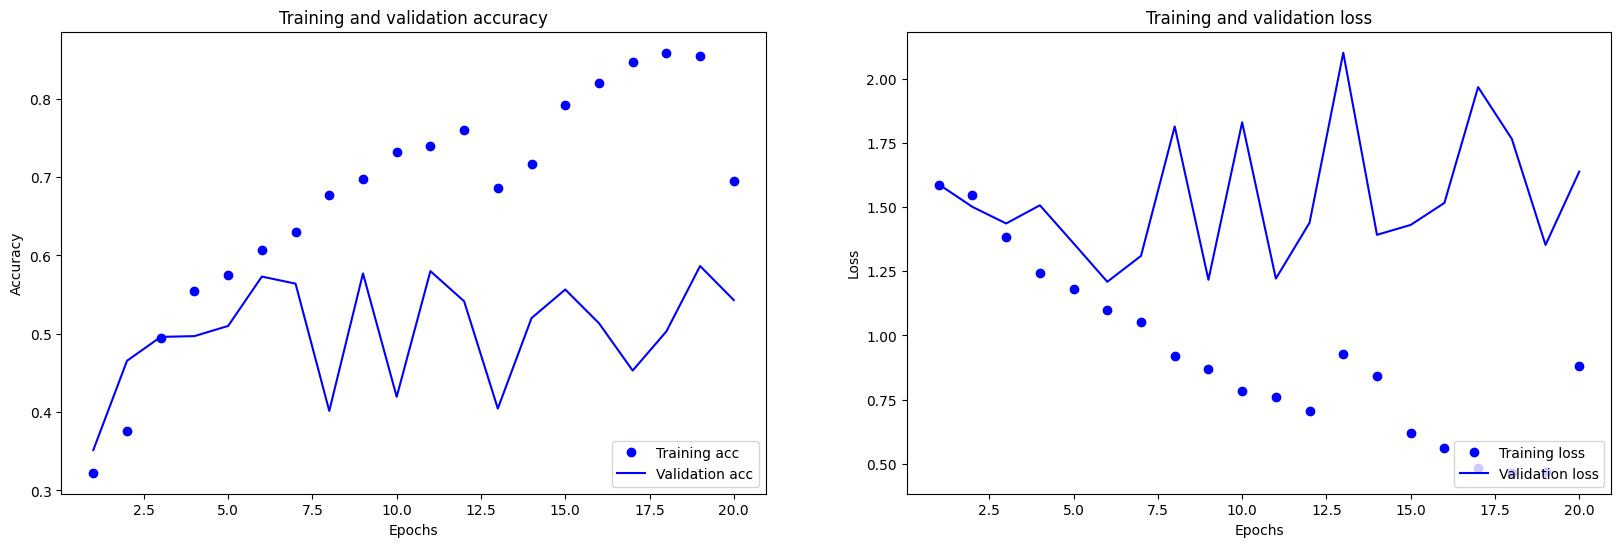

In [9]:
acc = history_rnn.history['accuracy']
val_acc = history_rnn.history['val_accuracy']
loss = history_rnn.history['loss']
val_loss = history_rnn.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

#### LSTM

In [10]:
embedding_dim = 64

model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.LSTM(embedding_dim, return_sequences=True),
  layers.LSTM(embedding_dim),
  layers.Dense(6, activation='softmax')])

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
epochs = 20
history_lstm = model.fit(
    train_tf_ds,
    validation_data=val_tf_ds,
    epochs=epochs)

Epoch 1/20
    499/Unknown 16s 25ms/step - accuracy: 0.3248 - loss: 1.6016

2024-05-18 23:41:08.168538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-05-18 23:41:08.168647: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8220564387108880791
2024-05-18 23:41:08.168660: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17398451920752008993
2024-05-18 23:41:08.168709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.3248 - loss: 1.6016 - val_accuracy: 0.3520 - val_loss: 1.5829
Epoch 2/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.3546 - loss: 1.5896

2024-05-18 23:41:09.150230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:41:09.150317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 23:41:09.150358: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3912317793080805563
2024-05-18 23:41:09.150370: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1571575311425912055


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3373 - loss: 1.5823

2024-05-18 23:41:18.301159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:41:18.301216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-05-18 23:41:18.301231: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8220564387108880791
2024-05-18 23:41:18.301237: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17398451920752008993
2024-05-18 23:41:18.301246: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18245586075003494072


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.3373 - loss: 1.5823 - val_accuracy: 0.3520 - val_loss: 1.5825
Epoch 3/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3567 - loss: 1.5879

2024-05-18 23:41:18.802830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:41:18.802890: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3912317793080805563
2024-05-18 23:41:18.802903: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1571575311425912055
2024-05-18 23:41:18.803036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3443 - loss: 1.5624

2024-05-18 23:41:27.866019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:41:27.866086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-05-18 23:41:27.866121: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8220564387108880791
2024-05-18 23:41:27.866134: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17398451920752008993


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.3443 - loss: 1.5622 - val_accuracy: 0.3735 - val_loss: 1.5313
Epoch 4/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.3712 - loss: 1.5712

2024-05-18 23:41:28.354681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:41:28.354730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 23:41:28.354750: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3912317793080805563
2024-05-18 23:41:28.354756: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1571575311425912055
2024-05-18 23:41:28.354762: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10362226458275964798


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3565 - loss: 1.5363

2024-05-18 23:41:37.952920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:41:37.952999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-05-18 23:41:37.953041: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8220564387108880791
2024-05-18 23:41:37.953055: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17398451920752008993


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.3565 - loss: 1.5364 - val_accuracy: 0.3520 - val_loss: 1.5827
Epoch 5/20
  4/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.3398 - loss: 1.5763

2024-05-18 23:41:38.500909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:41:38.500982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3405 - loss: 1.5817

2024-05-18 23:41:47.970479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:41:47.970577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-05-18 23:41:47.970613: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8220564387108880791
2024-05-18 23:41:47.970638: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17398451920752008993


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.3405 - loss: 1.5817 - val_accuracy: 0.3520 - val_loss: 1.5829
Epoch 6/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3567 - loss: 1.5895

2024-05-18 23:41:48.672190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:41:48.672234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 23:41:48.672247: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3912317793080805563
2024-05-18 23:41:48.672253: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1571575311425912055
2024-05-18 23:41:48.672263: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10362226458275964798


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3405 - loss: 1.5815

2024-05-18 23:41:58.607055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:41:58.607137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.3405 - loss: 1.5815 - val_accuracy: 0.3520 - val_loss: 1.5830
Epoch 7/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.3546 - loss: 1.5886

2024-05-18 23:41:59.207684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:41:59.207765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3405 - loss: 1.5814

2024-05-18 23:42:09.502616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:42:09.502688: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8220564387108880791
2024-05-18 23:42:09.502700: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17398451920752008993
2024-05-18 23:42:09.502761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.3405 - loss: 1.5814 - val_accuracy: 0.3520 - val_loss: 1.5832
Epoch 8/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.3546 - loss: 1.5897

2024-05-18 23:42:10.063510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:42:10.063582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3405 - loss: 1.5811

2024-05-18 23:42:20.485397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:42:20.485604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.3405 - loss: 1.5810 - val_accuracy: 0.3520 - val_loss: 1.5827
Epoch 9/20
  6/500 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.3535 - loss: 1.5860

2024-05-18 23:42:21.105512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:42:21.105548: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3912317793080805563
2024-05-18 23:42:21.105555: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1571575311425912055
2024-05-18 23:42:21.105696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3457 - loss: 1.5652

2024-05-18 23:42:31.416853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:42:31.416882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-05-18 23:42:31.416895: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8220564387108880791
2024-05-18 23:42:31.416900: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17398451920752008993
2024-05-18 23:42:31.416908: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18245586075003494072


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.3457 - loss: 1.5652 - val_accuracy: 0.3520 - val_loss: 1.5821
Epoch 10/20
  6/500 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.3535 - loss: 1.5823

2024-05-18 23:42:31.988811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:42:31.988871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 23:42:31.988885: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3912317793080805563
2024-05-18 23:42:31.988892: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1571575311425912055
2024-05-18 23:42:31.988901: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10362226458275964798


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3652 - loss: 1.4579

2024-05-18 23:42:42.272516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:42:42.272557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-05-18 23:42:42.272597: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8220564387108880791
2024-05-18 23:42:42.272615: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17398451920752008993


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.3652 - loss: 1.4577 - val_accuracy: 0.4345 - val_loss: 1.2039
Epoch 11/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.4726 - loss: 1.1768

2024-05-18 23:42:42.861278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:42:42.861318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4443 - loss: 1.1372

2024-05-18 23:42:53.017746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:42:53.017776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 23:42:53.017787: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8220564387108880791
2024-05-18 23:42:53.017793: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17398451920752008993


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.4443 - loss: 1.1370 - val_accuracy: 0.5085 - val_loss: 1.0605
Epoch 12/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5171 - loss: 0.9676

2024-05-18 23:42:53.611799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:42:53.611862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 23:42:53.611898: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3912317793080805563
2024-05-18 23:42:53.611910: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1571575311425912055


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6580 - loss: 0.8277

2024-05-18 23:43:03.825131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:43:03.825174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-05-18 23:43:03.825211: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8220564387108880791
2024-05-18 23:43:03.825223: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17398451920752008993


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.6585 - loss: 0.8269 - val_accuracy: 0.7915 - val_loss: 0.6276
Epoch 13/20


2024-05-18 23:43:04.356741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:43:04.356806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 23:43:04.356843: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3912317793080805563
2024-05-18 23:43:04.356855: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1571575311425912055


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8700 - loss: 0.3914

2024-05-18 23:43:23.348708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:43:23.348782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 23:43:23.348835: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8220564387108880791


500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.8700 - loss: 0.3913 - val_accuracy: 0.8660 - val_loss: 0.4107
Epoch 14/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9109 - loss: 0.2510

2024-05-18 23:43:23.883677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:43:23.883722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 23:43:23.883734: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3912317793080805563
2024-05-18 23:43:23.883741: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1571575311425912055
2024-05-18 23:43:23.883752: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10362226458275964798


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9216 - loss: 0.2366

2024-05-18 23:43:33.218677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:43:33.218760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9217 - loss: 0.2365 - val_accuracy: 0.8835 - val_loss: 0.3794
Epoch 15/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9440 - loss: 0.1667

2024-05-18 23:43:33.829733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:43:33.829809: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3912317793080805563
2024-05-18 23:43:33.829840: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1571575311425912055
2024-05-18 23:43:33.829872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9515 - loss: 0.1531

2024-05-18 23:43:43.248390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:43:43.248458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-05-18 23:43:43.248497: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8220564387108880791
2024-05-18 23:43:43.248511: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17398451920752008993


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9515 - loss: 0.1531 - val_accuracy: 0.8845 - val_loss: 0.3720
Epoch 16/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9696 - loss: 0.1311

2024-05-18 23:43:43.786339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:43:43.786952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9624 - loss: 0.1227

2024-05-18 23:43:53.113100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:43:53.113205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9624 - loss: 0.1227 - val_accuracy: 0.8855 - val_loss: 0.3810
Epoch 17/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9523 - loss: 0.1223

2024-05-18 23:43:53.711852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:43:53.711918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 23:43:53.711936: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3912317793080805563
2024-05-18 23:43:53.711947: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1571575311425912055


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9699 - loss: 0.0915

2024-05-18 23:44:03.727054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:44:03.727086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-05-18 23:44:03.727099: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8220564387108880791
2024-05-18 23:44:03.727105: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17398451920752008993
2024-05-18 23:44:03.727132: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18245586075003494072


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9699 - loss: 0.0915 - val_accuracy: 0.8910 - val_loss: 0.3990
Epoch 18/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9761 - loss: 0.0610

2024-05-18 23:44:04.267171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:44:04.267228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 23:44:04.267244: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3912317793080805563
2024-05-18 23:44:04.267251: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1571575311425912055
2024-05-18 23:44:04.267259: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10362226458275964798


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9757 - loss: 0.0775

2024-05-18 23:44:14.221048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:44:14.221211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9757 - loss: 0.0775 - val_accuracy: 0.8855 - val_loss: 0.4888
Epoch 19/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9846 - loss: 0.0512

2024-05-18 23:44:14.753106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:44:14.753171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 23:44:14.753207: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3912317793080805563
2024-05-18 23:44:14.753220: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1571575311425912055


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9778 - loss: 0.0749

2024-05-18 23:44:23.838914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:44:23.838959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-05-18 23:44:23.838973: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8220564387108880791
2024-05-18 23:44:23.838980: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17398451920752008993
2024-05-18 23:44:23.838988: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18245586075003494072


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9778 - loss: 0.0748 - val_accuracy: 0.8945 - val_loss: 0.4188
Epoch 20/20


2024-05-18 23:44:24.333071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:44:24.333146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 23:44:24.333185: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3912317793080805563
2024-05-18 23:44:24.333198: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1571575311425912055


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9836 - loss: 0.0523

2024-05-18 23:44:34.386737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:44:34.386796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-05-18 23:44:34.386813: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8220564387108880791
2024-05-18 23:44:34.386820: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17398451920752008993
2024-05-18 23:44:34.386828: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18245586075003494072


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9836 - loss: 0.0523 - val_accuracy: 0.8965 - val_loss: 0.4236


2024-05-18 23:44:34.944036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:44:34.944098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 23:44:34.944134: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3912317793080805563
2024-05-18 23:44:34.944148: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1571575311425912055


In [12]:
save_history(history_rnn, 'history_lstm')

loss, accuracy = model.evaluate(test_tf_ds)
new_row = pd.DataFrame({'Model': ['LSTM'], 'Accuracy': [accuracy], 'Loss': [loss]})
df_performance = pd.concat([df_performance, new_row], ignore_index=True)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

      1/Unknown 0s 14ms/step - accuracy: 0.9688 - loss: 0.3256

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8978 - loss: 0.4287
Loss:  0.43671879172325134
Accuracy:  0.8949999809265137


2024-05-18 23:44:35.580980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 23:44:35.581039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 23:44:35.581078: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3912317793080805563
2024-05-18 23:44:35.581097: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1571575311425912055


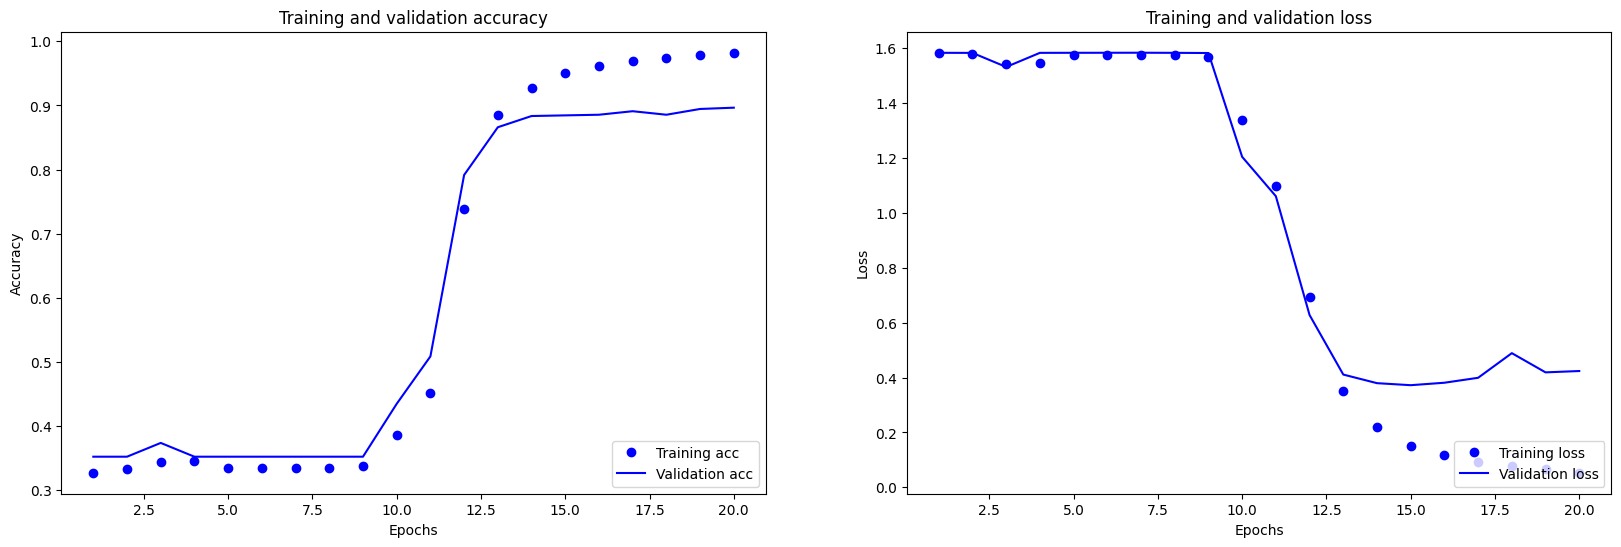

In [13]:
acc = history_lstm.history['accuracy']
val_acc = history_lstm.history['val_accuracy']
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

---
### Comparing Results

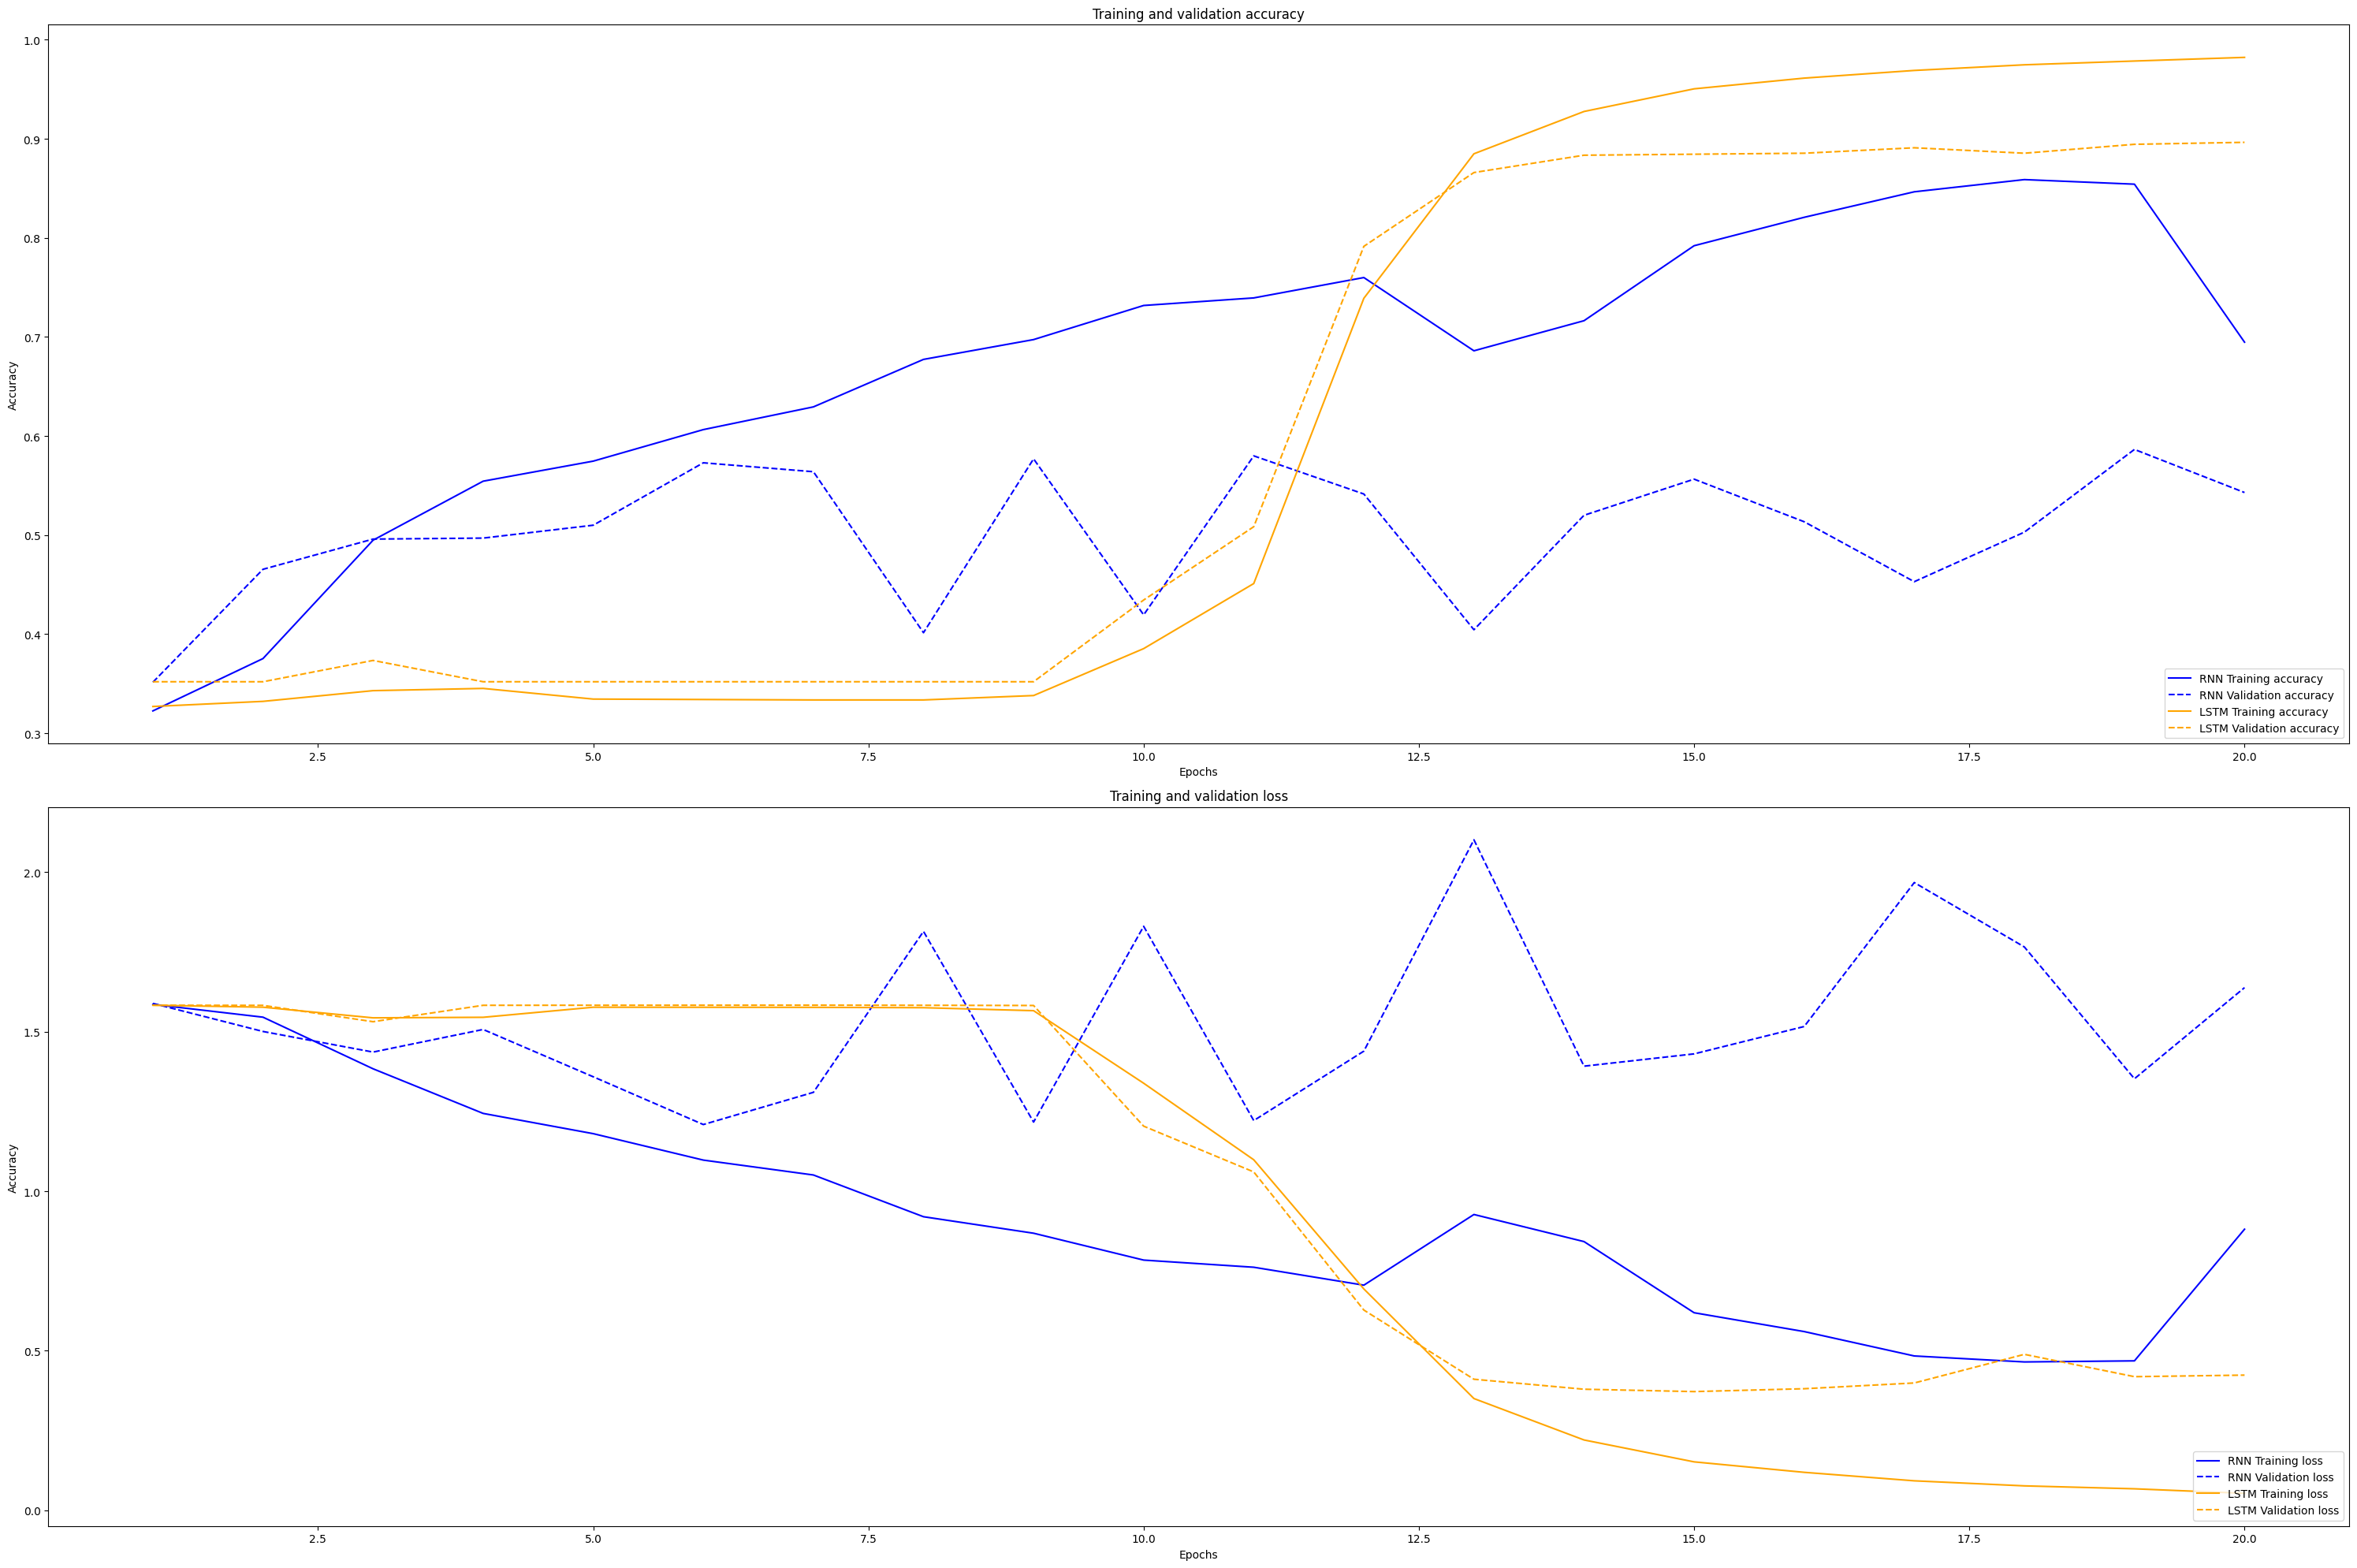

,Model,Accuracy,Loss
0,RNN,0.5515,1.624513
1,LSTM,0.8950,0.436719


In [15]:
rnn_accuracy = history_rnn.history['accuracy']
rnn_val_accuracy = history_rnn.history['val_accuracy']
rnn_loss = history_rnn.history['loss']
rnn_val_loss = history_rnn.history['val_loss']

lstm_accuracy = history_lstm.history['accuracy']
lstm_val_accuracy = history_lstm.history['val_accuracy']
lstm_loss = history_lstm.history['loss']
lstm_val_loss = history_lstm.history['val_loss']

epochs = range(1, len(rnn_accuracy) + 1)

plt.figure(figsize=(30, 20))

plt.subplot(2, 1, 1)
plt.plot(epochs, rnn_accuracy, 'b-', label='RNN Training accuracy')
plt.plot(epochs, rnn_val_accuracy, 'b--', label='RNN Validation accuracy')
plt.plot(epochs, lstm_accuracy, 'orange', label='LSTM Training accuracy')
plt.plot(epochs, lstm_val_accuracy, 'orange', linestyle='dashed', label='LSTM Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(epochs, rnn_loss, 'b-', label='RNN Training loss')
plt.plot(epochs, rnn_val_loss, 'b--', label='RNN Validation loss')
plt.plot(epochs, lstm_loss, 'orange', label='LSTM Training loss')
plt.plot(epochs, lstm_val_loss, 'orange', linestyle='dashed', label='LSTM Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

display(df_performance)

From the training history and the final accuracy and loss, we can safely determine that LSTM was the best performing model, with a margin of nearly 35% of accuracy over the RNN model. Naturally, the LSTM model also had a much lower loss. One curious aspect about the training history, is that the RNN model started to converge faster than the LSTM model, but it plateaued at a much lower accuracy and higher loss (in the 50 to 70% range), while the LSTM model kept improving and eventually surpassed the RNN model. Also, the difference between the validation accuracy and the training accuracy in the RNN is much more pronounced than in the LSTM model, which indicates that the RNN model may be overfitting the data.

## Question 2 (30 points)

Now download the pretrained word embedding models from Gensim library with different embedding size 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200'. Show the most similar words for `anger, fear, joy, love, sadness, and surprise`. Use the best performing model from the Quesetion 1 and replace the embedding layer with pretrained word embeddings with different embedding size. Explain whether these pretrained embedding would imporve the model performance.


In [27]:
import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [28]:
models_embedding = {}
for model_name in ['glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200']:
    models_embedding[model_name] = gensim.downloader.load(model_name)

---
### Show the most similar words for `anger, fear, joy, love, sadness, and surprise`

In [29]:
# Store the similar words for each emotion
words_of_interest = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
similar_words = {}
for model_name, model in models_embedding.items():
    similar_words[model_name] = {}
    for word in words_of_interest:
        try:
            similar_words[model_name][word] = model.most_similar(word)
        except KeyError:
            similar_words[model_name][word] = f"'{word}' not in vocabulary"

display(similar_words)

{'glove-twitter-25': {'anger': [('fear', 0.9505937695503235),
   ('frustration', 0.9350658059120178),
   ('emotions', 0.9121993780136108),
   ('pain', 0.9061965346336365),
   ('emotion', 0.9021011590957642),
   ('hatred', 0.9015483856201172),
   ('enemy', 0.9007921814918518),
   ('confusion', 0.8988509178161621),
   ('loneliness', 0.8956931829452515),
   ('jealousy', 0.8939906358718872)],
  'fear': [('anger', 0.9505937695503235),
   ('enemy', 0.9229838252067566),
   ('afraid', 0.9117358922958374),
   ('destroy', 0.9105901122093201),
   ('fears', 0.9076415300369263),
   ('lies', 0.8961015343666077),
   ('faith', 0.8939934968948364),
   ('hatred', 0.8898482918739319),
   ('overcome', 0.8887839317321777),
   ('truth', 0.8886940479278564)],
  'joy': [('dreams', 0.9211523532867432),
   ('faith', 0.9142656922340393),
   ('grace', 0.9103144407272339),
   ('happiness', 0.908566415309906),
   ('spirit', 0.9064580202102661),
   ('lord', 0.9043521881103516),
   ('heaven', 0.9041587114334106),
   

In [30]:
# Visualize
"""
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]

    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]

    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.annotate(word, (x, y), xytext=(x+0.05, y+0.05))


display_pca_scatterplot(model,
    ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
        'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
        'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
        'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
        'france', 'germany', 'hungary', 'luxembourg', 'australia', 'china', 'iran',
        'homework', 'assignment', 'problem', 'exam', 'test', 'class',
        'school', 'college', 'university', 'institute'])
"""

"\ndef display_pca_scatterplot(model, words=None, sample=0):\n    if words == None:\n        if sample > 0:\n            words = np.random.choice(list(model.vocab.keys()), sample)\n        else:\n            words = [ word for word in model.vocab ]\n\n    word_vectors = np.array([model[w] for w in words])\n\n    twodim = PCA().fit_transform(word_vectors)[:,:2]\n\n    plt.figure(figsize=(6,6))\n    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')\n    for word, (x,y) in zip(words, twodim):\n        plt.annotate(word, (x, y), xytext=(x+0.05, y+0.05))\n\n\ndisplay_pca_scatterplot(model,\n    ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',\n        'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',\n        'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',\n        'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',\n        'france', 'germany', 'hungary', 'luxembourg', 'australia', 'china', 'iran',\n  

---
### Train the LSTM models with different embedding size


In [31]:
# Get the vocalbulary of the dataset
vocabolary = vectorize_layer.get_vocabulary()
vocabolary_size = len(vocabolary)
epochs = 20

#### glove-twitter-25

In [32]:
# Use the LSTM we defined, but replace the embedding layer with pretrained embeddings
embedding_dim = 25
embedding_matrix = np.zeros((vocabolary_size, embedding_dim))

for i, word in enumerate(vocabolary):
    if word in models_embedding['glove-twitter-25'].key_to_index:
        embedding_matrix[i] = models_embedding['glove-twitter-25'][word]

model = tf.keras.Sequential([
    layers.Embedding(max_features,
                   embedding_dim,
                   embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                   trainable=False),
  layers.LSTM(embedding_dim, return_sequences=True),
  layers.LSTM(embedding_dim),
  layers.Dense(6, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
history_glove_25 = model.fit(
    train_tf_ds,
    validation_data=val_tf_ds,
    epochs=epochs)

Epoch 1/20
    499/Unknown 10s 16ms/step - accuracy: 0.3374 - loss: 1.6098

2024-05-18 19:33:25.984470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:33:25.984555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:33:25.984571: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:33:25.984576: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:33:25.984583: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at 

500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.3374 - loss: 1.6097 - val_accuracy: 0.3520 - val_loss: 1.5832
Epoch 2/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.3567 - loss: 1.5890

2024-05-18 19:33:26.685679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:33:26.686021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:33:26.686106: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:33:26.686126: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:33:26.686133: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3798 - loss: 1.5555

2024-05-18 19:33:34.510181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:33:34.510253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-05-18 19:33:34.510292: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:33:34.510322: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3801 - loss: 1.5552 - val_accuracy: 0.4730 - val_loss: 1.4239
Epoch 3/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.4630 - loss: 1.4405

2024-05-18 19:33:35.023617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:33:35.023692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4847 - loss: 1.3800

2024-05-18 19:33:42.891537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:33:42.891583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:33:42.891640: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:33:42.891649: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:33:42.891656: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.4848 - loss: 1.3798 - val_accuracy: 0.5205 - val_loss: 1.2864
Epoch 4/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.4925 - loss: 1.3311 

2024-05-18 19:33:43.440003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:33:43.440053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:33:43.440066: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:33:43.440074: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:33:43.440079: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5176 - loss: 1.2753

2024-05-18 19:33:51.233275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:33:51.233341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5177 - loss: 1.2752 - val_accuracy: 0.5265 - val_loss: 1.2315
Epoch 5/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5129 - loss: 1.2960

2024-05-18 19:33:51.741699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:33:51.741748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:33:51.741759: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:33:51.741766: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:33:51.741771: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5314 - loss: 1.2328

2024-05-18 19:33:59.652350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:33:59.652392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:33:59.652403: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:33:59.652410: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:33:59.652418: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5314 - loss: 1.2327 - val_accuracy: 0.5355 - val_loss: 1.1982
Epoch 6/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5188 - loss: 1.2865

2024-05-18 19:34:00.246086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:34:00.246136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:34:00.246148: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:34:00.246157: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:34:00.246162: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5362 - loss: 1.2102

2024-05-18 19:34:08.126354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:34:08.126405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:34:08.126417: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:34:08.126423: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:34:08.126429: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5362 - loss: 1.2101 - val_accuracy: 0.5440 - val_loss: 1.1808
Epoch 7/20
 11/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5054 - loss: 1.2607

2024-05-18 19:34:08.645141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:34:08.645294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5374 - loss: 1.1898

2024-05-18 19:34:16.483710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:34:16.483754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:34:16.483766: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:34:16.483774: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:34:16.483782: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5375 - loss: 1.1898 - val_accuracy: 0.5485 - val_loss: 1.1575
Epoch 8/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5160 - loss: 1.2557

2024-05-18 19:34:16.999625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]
2024-05-18 19:34:16.999684: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:34:16.999710: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:34:16.999737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5400 - loss: 1.1656

2024-05-18 19:34:24.646670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:34:24.646718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:34:24.646731: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:34:24.646737: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:34:24.646743: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5400 - loss: 1.1656 - val_accuracy: 0.5535 - val_loss: 1.1332
Epoch 9/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5088 - loss: 1.2191

2024-05-18 19:34:25.138566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:34:25.138611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:34:25.138623: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:34:25.138630: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:34:25.138635: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5533 - loss: 1.1349

2024-05-18 19:34:32.869042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:34:32.869215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5533 - loss: 1.1348 - val_accuracy: 0.5790 - val_loss: 1.1032
Epoch 10/20
 13/500 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5845 - loss: 1.1739

2024-05-18 19:34:33.413804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]
2024-05-18 19:34:33.413881: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:34:33.413910: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:34:33.413918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5776 - loss: 1.0986

2024-05-18 19:34:41.285712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:34:41.285755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:34:41.285767: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:34:41.285774: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:34:41.285781: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5776 - loss: 1.0986 - val_accuracy: 0.5910 - val_loss: 1.0657
Epoch 11/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5926 - loss: 1.1329

2024-05-18 19:34:41.787010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:34:41.787075: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:34:41.787104: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:34:41.787134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5983 - loss: 1.0507

2024-05-18 19:34:49.580427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:34:49.580474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:34:49.580486: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:34:49.580493: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:34:49.580500: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5983 - loss: 1.0506 - val_accuracy: 0.6035 - val_loss: 1.0252
Epoch 12/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5971 - loss: 1.0628

2024-05-18 19:34:50.068028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 19:34:50.068096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6153 - loss: 1.0031

2024-05-18 19:34:57.808931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:34:57.808990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:34:57.809027: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6153 - loss: 1.0029 - val_accuracy: 0.6235 - val_loss: 0.9676
Epoch 13/20


2024-05-18 19:34:58.314862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:34:58.315019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6329 - loss: 0.9436

2024-05-18 19:35:08.168915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:35:08.168995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-05-18 19:35:08.169031: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036
2024-05-18 19:35:08.169063: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6329 - loss: 0.9435 - val_accuracy: 0.6360 - val_loss: 0.9331
Epoch 14/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6260 - loss: 0.9433

2024-05-18 19:35:08.657717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:35:08.657790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6500 - loss: 0.8897

2024-05-18 19:35:16.531966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:35:16.532031: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:35:16.532040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6500 - loss: 0.8896 - val_accuracy: 0.6415 - val_loss: 0.9003
Epoch 15/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6216 - loss: 0.9304

2024-05-18 19:35:17.074977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:35:17.075037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:35:17.075073: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6704 - loss: 0.8423

2024-05-18 19:35:24.886457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 19:35:24.886524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6705 - loss: 0.8422 - val_accuracy: 0.6775 - val_loss: 0.8545
Epoch 16/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6533 - loss: 0.8603

2024-05-18 19:35:25.413911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:35:25.413956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:35:25.413968: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:35:25.413975: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:35:25.413980: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6981 - loss: 0.7800

2024-05-18 19:35:33.173254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:35:33.173303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:35:33.173314: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:35:33.173321: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:35:33.173327: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6982 - loss: 0.7798 - val_accuracy: 0.6905 - val_loss: 0.8230
Epoch 17/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6665 - loss: 0.8347

2024-05-18 19:35:33.656663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:35:33.656714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:35:33.656726: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:35:33.656734: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:35:33.656739: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7149 - loss: 0.7421

2024-05-18 19:35:41.445115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:35:41.445160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:35:41.445171: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:35:41.445178: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:35:41.445185: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7150 - loss: 0.7420 - val_accuracy: 0.7085 - val_loss: 0.7710
Epoch 18/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7045 - loss: 0.7694

2024-05-18 19:35:41.962821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:35:41.962886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7341 - loss: 0.6962

2024-05-18 19:35:49.916673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:35:49.916738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-05-18 19:35:49.916772: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:35:49.916804: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7342 - loss: 0.6962 - val_accuracy: 0.7320 - val_loss: 0.7154
Epoch 19/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7343 - loss: 0.7240

2024-05-18 19:35:50.396503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:35:50.396554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:35:50.396566: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:35:50.396574: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:35:50.396580: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7505 - loss: 0.6576

2024-05-18 19:35:58.147157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:35:58.147205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:35:58.147216: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:35:58.147223: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:35:58.147229: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7506 - loss: 0.6575 - val_accuracy: 0.7295 - val_loss: 0.7288
Epoch 20/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7360 - loss: 0.6881

2024-05-18 19:35:58.614442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:35:58.614743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:35:58.614795: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:35:58.614807: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:35:58.614813: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7654 - loss: 0.6303

2024-05-18 19:36:06.592952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:36:06.592996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:36:06.593008: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:36:06.593014: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:36:06.593021: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7654 - loss: 0.6303 - val_accuracy: 0.7425 - val_loss: 0.6710


2024-05-18 19:36:07.122395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:36:07.122487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


In [34]:
save_history(history_rnn, 'glove-twitter-25')

loss, accuracy = model.evaluate(test_tf_ds)
new_row = pd.DataFrame({'Model': ['glove-twitter-25'], 'Accuracy': [accuracy], 'Loss': [loss]})
df_performance = pd.concat([df_performance, new_row], ignore_index=True)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

      1/Unknown 0s 14ms/step - accuracy: 0.7812 - loss: 0.6176

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7537 - loss: 0.6661
Loss:  0.6802605390548706
Accuracy:  0.7459999918937683


2024-05-18 19:36:07.675121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:36:07.675173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:36:07.675187: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:36:07.675195: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:36:07.675200: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


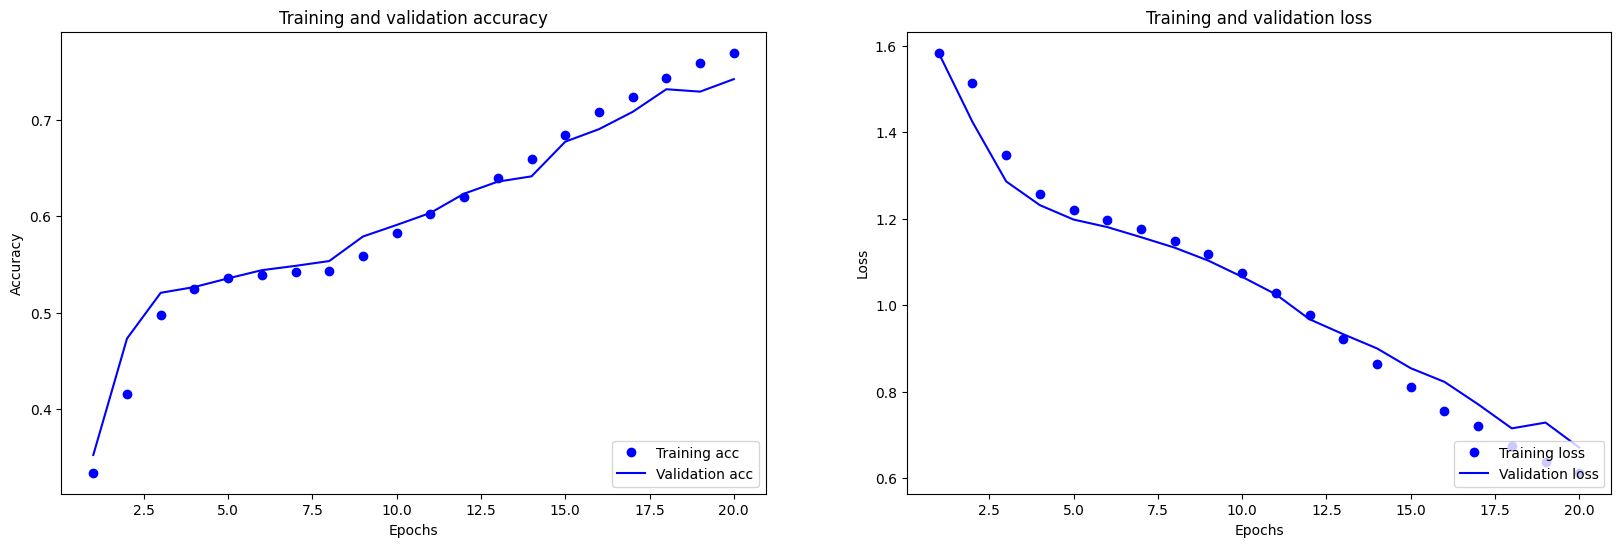

In [35]:
acc = history_glove_25.history['accuracy']
val_acc = history_glove_25.history['val_accuracy']
loss = history_glove_25.history['loss']
val_loss = history_glove_25.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

#### glove-twitter-50

In [36]:
embedding_dim = 50
embedding_matrix = np.zeros((vocabolary_size, embedding_dim))

for i, word in enumerate(vocabolary):
    if word in models_embedding['glove-twitter-50'].key_to_index:
        embedding_matrix[i] = models_embedding['glove-twitter-50'][word]

model = tf.keras.Sequential([
  layers.Embedding(max_features,
                   embedding_dim,
                   embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                   trainable=False),
  layers.LSTM(embedding_dim, return_sequences=True),
  layers.LSTM(embedding_dim),
  layers.Dense(6, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [37]:
epochs = 20
history_glove_50 = model.fit(
    train_tf_ds,
    validation_data=val_tf_ds,
    epochs=epochs)

Epoch 1/20
    500/Unknown 10s 16ms/step - accuracy: 0.3650 - loss: 1.5713

2024-05-18 19:36:18.042567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:36:18.042650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.3651 - loss: 1.5710 - val_accuracy: 0.5200 - val_loss: 1.3210
Epoch 2/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.4741 - loss: 1.3855

2024-05-18 19:36:18.750037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:36:18.750099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:36:18.750113: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:36:18.750119: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:36:18.750124: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5269 - loss: 1.2723

2024-05-18 19:36:27.154234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:36:27.154296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.5269 - loss: 1.2722 - val_accuracy: 0.5510 - val_loss: 1.1887
Epoch 3/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5266 - loss: 1.2471

2024-05-18 19:36:27.690717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:36:27.690779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 19:36:27.690815: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:36:27.690827: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5477 - loss: 1.1810

2024-05-18 19:36:35.662366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:36:35.662428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5477 - loss: 1.1809 - val_accuracy: 0.5680 - val_loss: 1.1156
Epoch 4/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5442 - loss: 1.1906

2024-05-18 19:36:36.166532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:36:36.166581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:36:36.166593: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:36:36.166628: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:36:36.166634: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5691 - loss: 1.1077

2024-05-18 19:36:44.070086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:36:44.070146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5692 - loss: 1.1076 - val_accuracy: 0.5960 - val_loss: 1.0504
Epoch 5/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6233 - loss: 1.0988

2024-05-18 19:36:44.589168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:36:44.589244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6308 - loss: 0.9968

2024-05-18 19:36:52.403123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:36:52.403171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:36:52.403182: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:36:52.403187: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:36:52.403194: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6308 - loss: 0.9967 - val_accuracy: 0.6715 - val_loss: 0.8966
Epoch 6/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6519 - loss: 0.9459

2024-05-18 19:36:52.951426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:36:52.951503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:36:52.951514: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:36:52.951521: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:36:52.951525: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7074 - loss: 0.8295

2024-05-18 19:37:00.947074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:37:00.947149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7075 - loss: 0.8293 - val_accuracy: 0.7260 - val_loss: 0.7674
Epoch 7/20
 12/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7096 - loss: 0.8308

2024-05-18 19:37:01.423649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:37:01.423709: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:37:01.423736: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566
2024-05-18 19:37:01.423765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7589 - loss: 0.6927

2024-05-18 19:37:09.571120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:37:09.571183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7589 - loss: 0.6926 - val_accuracy: 0.7705 - val_loss: 0.6499
Epoch 8/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7352 - loss: 0.7937

2024-05-18 19:37:10.046459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:37:10.046508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:37:10.046521: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:37:10.046529: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:37:10.046534: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7843 - loss: 0.6223

2024-05-18 19:37:18.038161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:37:18.038247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7844 - loss: 0.6221 - val_accuracy: 0.7925 - val_loss: 0.5753
Epoch 9/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.7555 - loss: 0.6864

2024-05-18 19:37:18.542128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:37:18.542196: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:37:18.542236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8098 - loss: 0.5316

2024-05-18 19:37:26.602892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:37:26.602957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8098 - loss: 0.5316 - val_accuracy: 0.7975 - val_loss: 0.5208
Epoch 10/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7817 - loss: 0.6045

2024-05-18 19:37:27.142262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:37:27.142585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:37:27.142600: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:37:27.142627: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:37:27.142636: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8291 - loss: 0.4743

2024-05-18 19:37:35.370335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:37:35.370403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8291 - loss: 0.4743 - val_accuracy: 0.8175 - val_loss: 0.4808
Epoch 11/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8470 - loss: 0.5070

2024-05-18 19:37:35.864317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:37:35.864387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 19:37:35.864423: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:37:35.864435: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8395 - loss: 0.4230

2024-05-18 19:37:44.167151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:37:44.167218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8395 - loss: 0.4229 - val_accuracy: 0.8495 - val_loss: 0.4154
Epoch 12/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8406 - loss: 0.4407

2024-05-18 19:37:44.668875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:37:44.668937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8576 - loss: 0.3844

2024-05-18 19:37:53.667428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:37:53.667508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8576 - loss: 0.3844 - val_accuracy: 0.8555 - val_loss: 0.3972
Epoch 13/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8940 - loss: 0.4119

2024-05-18 19:37:54.178054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:37:54.178119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8674 - loss: 0.3584

2024-05-18 19:38:02.752019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:38:02.752098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8674 - loss: 0.3584 - val_accuracy: 0.8635 - val_loss: 0.3787
Epoch 14/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9005 - loss: 0.3642

2024-05-18 19:38:03.245312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:38:03.245373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8871 - loss: 0.3081

2024-05-18 19:38:11.746275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:38:11.746329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8871 - loss: 0.3081 - val_accuracy: 0.8775 - val_loss: 0.3590
Epoch 15/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9361 - loss: 0.3304

2024-05-18 19:38:12.264948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:38:12.265009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 19:38:12.265044: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:38:12.265056: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8998 - loss: 0.2848

2024-05-18 19:38:20.415537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:38:20.415608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8998 - loss: 0.2848 - val_accuracy: 0.8820 - val_loss: 0.3501
Epoch 16/20
 10/500 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8862 - loss: 0.3538

2024-05-18 19:38:20.916703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:38:20.916774: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:38:20.916804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9051 - loss: 0.2603

2024-05-18 19:38:29.079322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:38:29.079404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9051 - loss: 0.2602 - val_accuracy: 0.8800 - val_loss: 0.3482
Epoch 17/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9218 - loss: 0.2854

2024-05-18 19:38:29.585796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:38:29.585859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9137 - loss: 0.2400

2024-05-18 19:38:37.818817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:38:37.818924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9137 - loss: 0.2400 - val_accuracy: 0.8865 - val_loss: 0.3186
Epoch 18/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9306 - loss: 0.2679

2024-05-18 19:38:38.320000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:38:38.320060: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:38:38.320090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9194 - loss: 0.2237

2024-05-18 19:38:46.613784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:38:46.613836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:38:46.613850: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:38:46.613942: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:38:46.613953: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9194 - loss: 0.2237 - val_accuracy: 0.8970 - val_loss: 0.2981
Epoch 19/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9245 - loss: 0.2574

2024-05-18 19:38:47.087640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:38:47.087703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]
2024-05-18 19:38:47.087737: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9243 - loss: 0.2048

2024-05-18 19:38:55.299538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:38:55.299609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9243 - loss: 0.2048 - val_accuracy: 0.8940 - val_loss: 0.2986
Epoch 20/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9360 - loss: 0.2404 

2024-05-18 19:38:55.818790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:38:55.818852: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:38:55.818879: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566
2024-05-18 19:38:55.818907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9250 - loss: 0.1943

2024-05-18 19:39:03.885420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:39:03.885479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9250 - loss: 0.1943 - val_accuracy: 0.9000 - val_loss: 0.2916


2024-05-18 19:39:04.361348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:39:04.361409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 19:39:04.361443: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:39:04.361455: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


In [38]:
save_history(history_rnn, 'glove-twitter-50')

loss, accuracy = model.evaluate(test_tf_ds)
new_row = pd.DataFrame({'Model': ['glove-twitter-50'], 'Accuracy': [accuracy], 'Loss': [loss]})
df_performance = pd.concat([df_performance, new_row], ignore_index=True)


print("Loss: ", loss)
print("Accuracy: ", accuracy)

      1/Unknown 0s 10ms/step - accuracy: 1.0000 - loss: 0.0583

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8981 - loss: 0.2945
Loss:  0.3310096561908722
Accuracy:  0.8889999985694885


2024-05-18 19:39:04.992411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:39:04.992485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


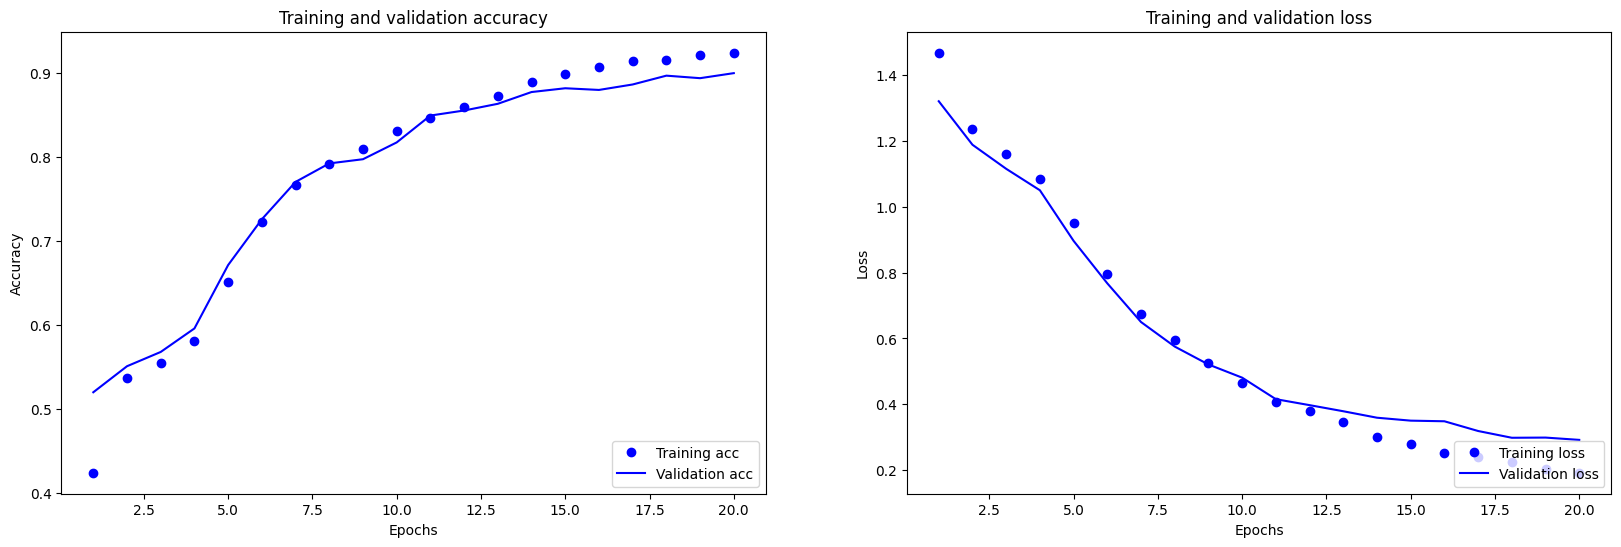

In [39]:
acc = history_glove_50.history['accuracy']
val_acc = history_glove_50.history['val_accuracy']
loss = history_glove_50.history['loss']
val_loss = history_glove_50.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

#### glove-twitter-100

In [40]:
embedding_dim = 100
embedding_matrix = np.zeros((vocabolary_size, embedding_dim))

for i, word in enumerate(vocabolary):
    if word in models_embedding['glove-twitter-100'].key_to_index:
        embedding_matrix[i] = models_embedding['glove-twitter-100'][word]

model = tf.keras.Sequential([
  layers.Embedding(max_features,
                   embedding_dim,
                   embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                   trainable=False),
  layers.LSTM(embedding_dim, return_sequences=True),
  layers.LSTM(embedding_dim),
  layers.Dense(6, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
epochs = 20
history_glove_100 = model.fit(
    train_tf_ds,
    validation_data=val_tf_ds,
    epochs=epochs)

Epoch 1/20
    500/Unknown 11s 17ms/step - accuracy: 0.3862 - loss: 1.5273

2024-05-18 19:39:16.083104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:39:16.083195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.3863 - loss: 1.5270 - val_accuracy: 0.5625 - val_loss: 1.1836
Epoch 2/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5353 - loss: 1.2516

2024-05-18 19:39:16.823191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:39:16.823290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5739 - loss: 1.1327

2024-05-18 19:39:25.208562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:39:25.208631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.5740 - loss: 1.1324 - val_accuracy: 0.6850 - val_loss: 0.8584
Epoch 3/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6541 - loss: 0.9946

2024-05-18 19:39:25.744830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:39:25.745010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:39:25.745236: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:39:25.745251: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:39:25.745257: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7334 - loss: 0.7783

2024-05-18 19:39:34.134865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:39:34.134957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7336 - loss: 0.7780 - val_accuracy: 0.8055 - val_loss: 0.5736
Epoch 4/20


2024-05-18 19:39:34.637381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:39:34.637426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:39:34.637438: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:39:34.637446: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:39:34.637450: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8296 - loss: 0.5065

2024-05-18 19:39:44.206816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:39:44.206866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:39:44.206877: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:39:44.206883: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:39:44.206889: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8297 - loss: 0.5061 - val_accuracy: 0.8775 - val_loss: 0.3797
Epoch 5/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8634 - loss: 0.4496

2024-05-18 19:39:44.716694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:39:44.716749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:39:44.717036: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:39:44.717083: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:39:44.717090: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8786 - loss: 0.3633

2024-05-18 19:39:53.176097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:39:53.176180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8786 - loss: 0.3633 - val_accuracy: 0.8930 - val_loss: 0.2830
Epoch 6/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9076 - loss: 0.2880

2024-05-18 19:39:53.739764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:39:53.739810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:39:53.739823: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:39:53.739832: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:39:53.739836: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9109 - loss: 0.2500

2024-05-18 19:40:02.308198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:40:02.308273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9109 - loss: 0.2500 - val_accuracy: 0.8980 - val_loss: 0.2801
Epoch 7/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9226 - loss: 0.3139

2024-05-18 19:40:02.898712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:40:02.898799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:40:02.898816: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:40:02.898826: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:40:02.898832: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9265 - loss: 0.2117

2024-05-18 19:40:11.491100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:40:11.491175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9265 - loss: 0.2117 - val_accuracy: 0.9170 - val_loss: 0.2321
Epoch 8/20
 11/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9198 - loss: 0.1858

2024-05-18 19:40:12.012422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]
2024-05-18 19:40:12.012489: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:40:12.012500: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:40:12.012512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9336 - loss: 0.1709

2024-05-18 19:40:20.409153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:40:20.409212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9336 - loss: 0.1709 - val_accuracy: 0.9190 - val_loss: 0.2086
Epoch 9/20


2024-05-18 19:40:20.936381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:40:20.936430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:40:20.936442: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:40:20.936450: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:40:20.936455: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9378 - loss: 0.1511

2024-05-18 19:40:30.273551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:40:30.273622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9377 - loss: 0.1512 - val_accuracy: 0.9235 - val_loss: 0.1954
Epoch 10/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9427 - loss: 0.1623

2024-05-18 19:40:30.754289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:40:30.754337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:40:30.754349: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:40:30.754357: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:40:30.754362: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9404 - loss: 0.1457

2024-05-18 19:40:38.968370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:40:38.968437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9404 - loss: 0.1457 - val_accuracy: 0.9220 - val_loss: 0.1842
Epoch 11/20


2024-05-18 19:40:39.476047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:40:39.476096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:40:39.476109: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:40:39.476117: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:40:39.476122: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9439 - loss: 0.1248

2024-05-18 19:40:49.297104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:40:49.297175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9439 - loss: 0.1248 - val_accuracy: 0.9195 - val_loss: 0.1955
Epoch 12/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9486 - loss: 0.1316

2024-05-18 19:40:49.824768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:40:49.824828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:40:49.824840: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:40:49.824849: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:40:49.824853: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9466 - loss: 0.1237

2024-05-18 19:40:58.547419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:40:58.547512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9466 - loss: 0.1237 - val_accuracy: 0.9230 - val_loss: 0.1991
Epoch 13/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9432 - loss: 0.1147

2024-05-18 19:40:59.095738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:40:59.095784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:40:59.095797: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:40:59.095805: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:40:59.095809: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9509 - loss: 0.1107

2024-05-18 19:41:07.461043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:41:07.461109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9509 - loss: 0.1107 - val_accuracy: 0.9270 - val_loss: 0.1903
Epoch 14/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9413 - loss: 0.1213

2024-05-18 19:41:07.966691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:41:07.966751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:41:07.966764: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:41:07.966773: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:41:07.966778: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9491 - loss: 0.1144

2024-05-18 19:41:16.317245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:41:16.317322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9491 - loss: 0.1144 - val_accuracy: 0.9215 - val_loss: 0.2071
Epoch 15/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9489 - loss: 0.1212

2024-05-18 19:41:16.853723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:41:16.853773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:41:16.853784: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:41:16.853791: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:41:16.853796: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9512 - loss: 0.1098

2024-05-18 19:41:25.234088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:41:25.234158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9512 - loss: 0.1097 - val_accuracy: 0.9245 - val_loss: 0.2133
Epoch 16/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9654 - loss: 0.0778

2024-05-18 19:41:25.738014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:41:25.738067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:41:25.738079: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:41:25.738087: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:41:25.738092: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9549 - loss: 0.0988

2024-05-18 19:41:34.120343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 19:41:34.120407: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036
2024-05-18 19:41:34.120435: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:41:34.120463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9549 - loss: 0.0988 - val_accuracy: 0.9250 - val_loss: 0.1965
Epoch 17/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9598 - loss: 0.0921

2024-05-18 19:41:34.652387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:41:34.652435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:41:34.652447: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:41:34.652454: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:41:34.652460: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9577 - loss: 0.0933

2024-05-18 19:41:43.279967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:41:43.280024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9577 - loss: 0.0933 - val_accuracy: 0.9325 - val_loss: 0.1702
Epoch 18/20
 11/500 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9696 - loss: 0.0659

2024-05-18 19:41:43.800993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:41:43.801038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:41:43.801050: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:41:43.801057: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:41:43.801062: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9558 - loss: 0.0931

2024-05-18 19:41:52.113392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:41:52.113459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9558 - loss: 0.0931 - val_accuracy: 0.9330 - val_loss: 0.1899
Epoch 19/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9870 - loss: 0.0442

2024-05-18 19:41:52.639373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:41:52.639429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:41:52.639442: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:41:52.639450: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:41:52.639455: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9595 - loss: 0.0870

2024-05-18 19:42:00.963951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:42:00.964015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9595 - loss: 0.0870 - val_accuracy: 0.9310 - val_loss: 0.1790
Epoch 20/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9617 - loss: 0.0731

2024-05-18 19:42:01.497651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:42:01.497700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:42:01.497712: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:42:01.497720: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:42:01.497724: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9618 - loss: 0.0832

2024-05-18 19:42:09.925050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:42:09.925133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9618 - loss: 0.0833 - val_accuracy: 0.9290 - val_loss: 0.1945


2024-05-18 19:42:10.461913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:42:10.461964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:42:10.461976: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:42:10.461984: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:42:10.461989: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


In [42]:
save_history(history_rnn, 'glove-twitter-100')

loss, accuracy = model.evaluate(test_tf_ds)
new_row = pd.DataFrame({'Model': ['glove-twitter-100'], 'Accuracy': [accuracy], 'Loss': [loss]})
df_performance = pd.concat([df_performance, new_row], ignore_index=True)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9216 - loss: 0.2343
Loss:  0.22603124380111694
Accuracy:  0.921500027179718


2024-05-18 19:42:11.114690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:42:11.114749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:42:11.114765: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:42:11.114783: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:42:11.114790: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


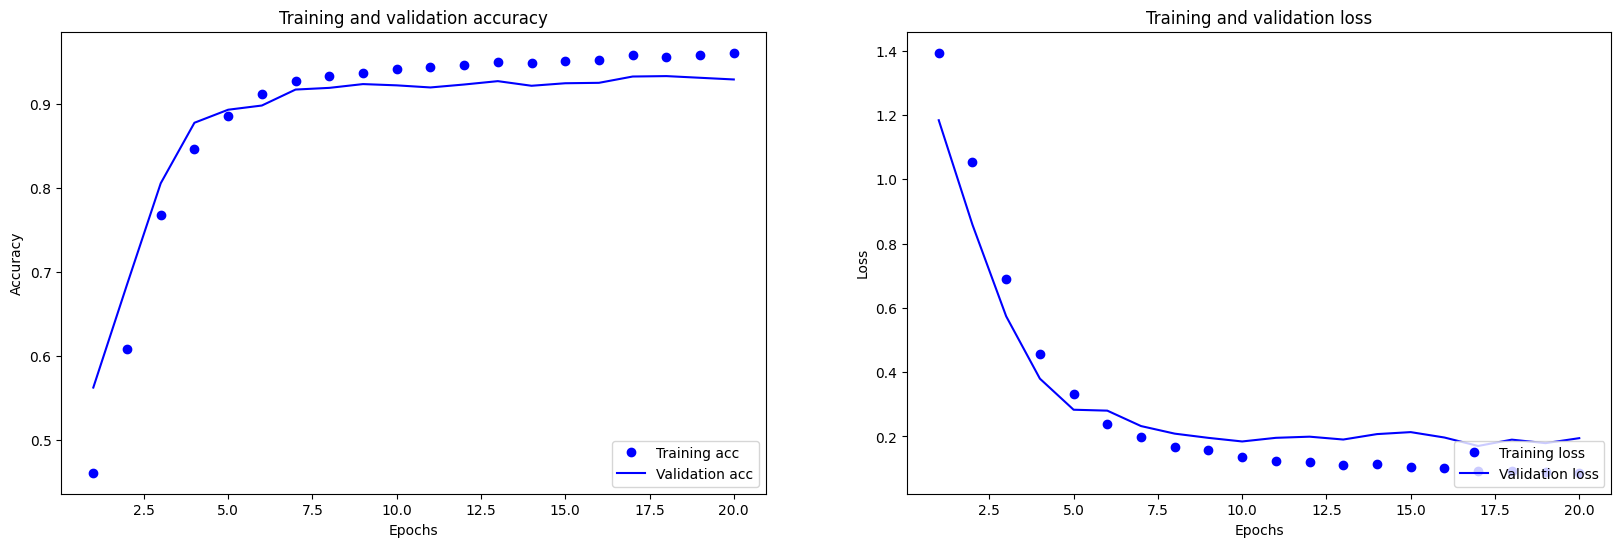

In [43]:
acc = history_glove_100.history['accuracy']
val_acc = history_glove_100.history['val_accuracy']
loss = history_glove_100.history['loss']
val_loss = history_glove_100.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

#### glove-twitter-200

In [44]:
embedding_dim = 200
embedding_matrix = np.zeros((vocabolary_size, embedding_dim))

for i, word in enumerate(vocabolary):
    if word in models_embedding['glove-twitter-200'].key_to_index:
        embedding_matrix[i] = models_embedding['glove-twitter-200'][word]

model = tf.keras.Sequential([
  layers.Embedding(max_features,
                   embedding_dim,
                   embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                   trainable=False),
  layers.LSTM(embedding_dim, return_sequences=True),
  layers.LSTM(embedding_dim),
  layers.Dense(6, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [45]:
epochs = 20
history_glove_200 = model.fit(
    train_tf_ds,
    validation_data=val_tf_ds,
    epochs=epochs)

Epoch 1/20
    497/Unknown 11s 18ms/step - accuracy: 0.4032 - loss: 1.4989

2024-05-18 19:42:23.071086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:42:23.071166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.4039 - loss: 1.4976 - val_accuracy: 0.5825 - val_loss: 1.1220
Epoch 2/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5485 - loss: 1.1605

2024-05-18 19:42:23.815876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:42:23.815937: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:42:23.815966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6047 - loss: 1.0437

2024-05-18 19:42:32.771411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:42:32.771459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:42:32.771471: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:42:32.771476: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:42:32.771483: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6050 - loss: 1.0433 - val_accuracy: 0.7735 - val_loss: 0.7207
Epoch 3/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7889 - loss: 0.7528

2024-05-18 19:42:33.348302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:42:33.348351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:42:33.348372: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:42:33.348378: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:42:33.348383: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8059 - loss: 0.5894

2024-05-18 19:42:42.180444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:42:42.180494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:42:42.180506: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:42:42.180512: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:42:42.180519: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8061 - loss: 0.5889 - val_accuracy: 0.8400 - val_loss: 0.4742
Epoch 4/20


2024-05-18 19:42:42.718329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:42:42.718393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8607 - loss: 0.3927

2024-05-18 19:42:52.374581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:42:52.374651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8608 - loss: 0.3925 - val_accuracy: 0.9235 - val_loss: 0.2422
Epoch 5/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9266 - loss: 0.2391

2024-05-18 19:42:52.975251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:42:52.975311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9226 - loss: 0.2272

2024-05-18 19:43:01.782938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:43:01.782994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:43:01.783007: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:43:01.783013: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:43:01.783019: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9226 - loss: 0.2271 - val_accuracy: 0.9320 - val_loss: 0.1974
Epoch 6/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9429 - loss: 0.1682

2024-05-18 19:43:02.356049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:43:02.356113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9311 - loss: 0.1770

2024-05-18 19:43:11.511094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:43:11.511163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9311 - loss: 0.1770 - val_accuracy: 0.9245 - val_loss: 0.1887
Epoch 7/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9412 - loss: 0.1508

2024-05-18 19:43:12.027951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-18 19:43:12.028016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9381 - loss: 0.1466

2024-05-18 19:43:20.625734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:43:20.625811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9381 - loss: 0.1466 - val_accuracy: 0.9320 - val_loss: 0.1523
Epoch 8/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9437 - loss: 0.1194

2024-05-18 19:43:21.198406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:43:21.198473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9420 - loss: 0.1182

2024-05-18 19:43:29.832422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:43:29.832566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9420 - loss: 0.1182 - val_accuracy: 0.9320 - val_loss: 0.1558
Epoch 9/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9363 - loss: 0.1183

2024-05-18 19:43:30.418905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:43:30.418966: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:43:30.418995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9456 - loss: 0.1130

2024-05-18 19:43:39.260514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:43:39.260553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:43:39.260562: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:43:39.260568: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:43:39.260574: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9456 - loss: 0.1130 - val_accuracy: 0.9325 - val_loss: 0.1445
Epoch 10/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9484 - loss: 0.1064 

2024-05-18 19:43:39.818129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:43:39.818177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:43:39.818190: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:43:39.818198: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:43:39.818203: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9489 - loss: 0.1080

2024-05-18 19:43:48.819457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:43:48.819505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:43:48.819523: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:43:48.819532: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:43:48.819542: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9489 - loss: 0.1080 - val_accuracy: 0.9415 - val_loss: 0.1392
Epoch 11/20
 11/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9491 - loss: 0.0910

2024-05-18 19:43:49.423410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:43:49.423499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9540 - loss: 0.0970

2024-05-18 19:43:58.384055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:43:58.384126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9540 - loss: 0.0971 - val_accuracy: 0.9370 - val_loss: 0.1393
Epoch 12/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9675 - loss: 0.0892

2024-05-18 19:43:58.963943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:43:58.963991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:43:58.964002: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:43:58.964010: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:43:58.964014: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9551 - loss: 0.0906

2024-05-18 19:44:07.931741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:44:07.931824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9551 - loss: 0.0907 - val_accuracy: 0.9260 - val_loss: 0.1503
Epoch 13/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9632 - loss: 0.1133

2024-05-18 19:44:08.478855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:44:08.478901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:44:08.478914: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:44:08.478922: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:44:08.478928: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9561 - loss: 0.0923

2024-05-18 19:44:17.200978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:44:17.201046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9561 - loss: 0.0923 - val_accuracy: 0.9330 - val_loss: 0.1447
Epoch 14/20
  9/500 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9823 - loss: 0.0642

2024-05-18 19:44:17.778981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:44:17.779046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9625 - loss: 0.0797

2024-05-18 19:44:26.432323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:44:26.432368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:44:26.432381: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:44:26.432387: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:44:26.432395: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9624 - loss: 0.0797 - val_accuracy: 0.9305 - val_loss: 0.2028
Epoch 15/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9813 - loss: 0.0874

2024-05-18 19:44:26.952872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:44:26.952920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:44:26.952932: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:44:26.952940: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:44:26.952945: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9611 - loss: 0.0837

2024-05-18 19:44:35.601149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:44:35.601214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9611 - loss: 0.0837 - val_accuracy: 0.9330 - val_loss: 0.1485
Epoch 16/20
 10/500 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9848 - loss: 0.0651

2024-05-18 19:44:36.185778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:44:36.185840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9677 - loss: 0.0726

2024-05-18 19:44:44.656124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:44:44.656189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9677 - loss: 0.0726 - val_accuracy: 0.9345 - val_loss: 0.1554
Epoch 17/20
  7/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9849 - loss: 0.0584 

2024-05-18 19:44:45.241153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:44:45.241205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:44:45.241221: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:44:45.241230: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:44:45.241236: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9685 - loss: 0.0712

2024-05-18 19:44:53.823946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:44:53.824014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9685 - loss: 0.0713 - val_accuracy: 0.9265 - val_loss: 0.1713
Epoch 18/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9552 - loss: 0.0944

2024-05-18 19:44:54.374396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:44:54.374445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:44:54.374457: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:44:54.374465: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:44:54.374470: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9631 - loss: 0.0805

2024-05-18 19:45:03.245468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:45:03.245540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9631 - loss: 0.0805 - val_accuracy: 0.9350 - val_loss: 0.1656
Epoch 19/20
  8/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9936 - loss: 0.0494

2024-05-18 19:45:03.755517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:45:03.755580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9705 - loss: 0.0639

2024-05-18 19:45:12.293415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:45:12.293481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9705 - loss: 0.0639 - val_accuracy: 0.9305 - val_loss: 0.2051
Epoch 20/20
 10/500 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9865 - loss: 0.0464

2024-05-18 19:45:12.890267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:45:12.890315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:45:12.890327: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705
2024-05-18 19:45:12.890335: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10302099563955855422
2024-05-18 19:45:12.890341: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12743862059294979566


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9708 - loss: 0.0637

2024-05-18 19:45:21.378385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:45:21.378443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:45:21.378457: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9665625481329077333
2024-05-18 19:45:21.378464: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5917358330827188033
2024-05-18 19:45:21.378471: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2444496660603381036


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9708 - loss: 0.0637 - val_accuracy: 0.9310 - val_loss: 0.2079


2024-05-18 19:45:21.974498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:45:21.974560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-18 19:45:21.974595: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10896763003798456705


In [46]:
save_history(history_rnn, 'glove-twitter-200')

loss, accuracy = model.evaluate(test_tf_ds)
new_row = pd.DataFrame({'Model': ['glove-twitter-200'], 'Accuracy': [accuracy], 'Loss': [loss]})
df_performance = pd.concat([df_performance, new_row], ignore_index=True)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

      1/Unknown 0s 10ms/step - accuracy: 0.9375 - loss: 0.0878

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9296 - loss: 0.1830
Loss:  0.1905623972415924
Accuracy:  0.9284999966621399


2024-05-18 19:45:22.646293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-18 19:45:22.646354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


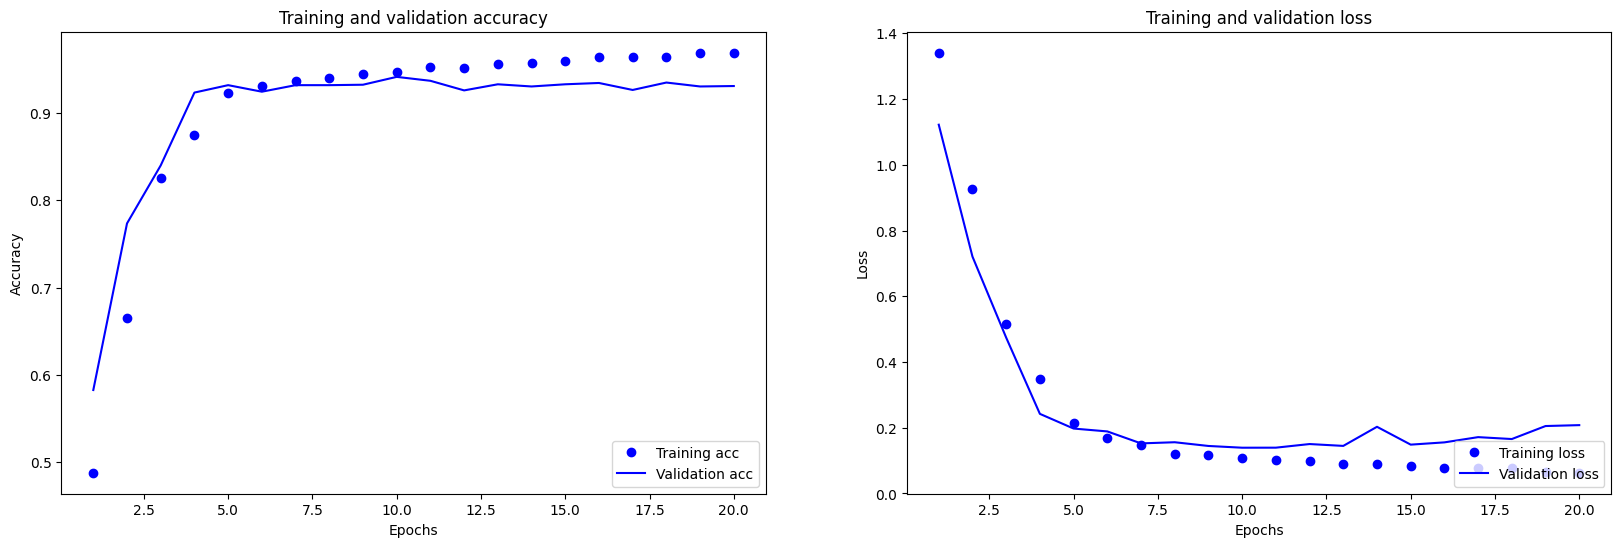

In [47]:
acc = history_glove_200.history['accuracy']
val_acc = history_glove_200.history['val_accuracy']
loss = history_glove_200.history['loss']
val_loss = history_glove_200.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

---
### Comparing Results

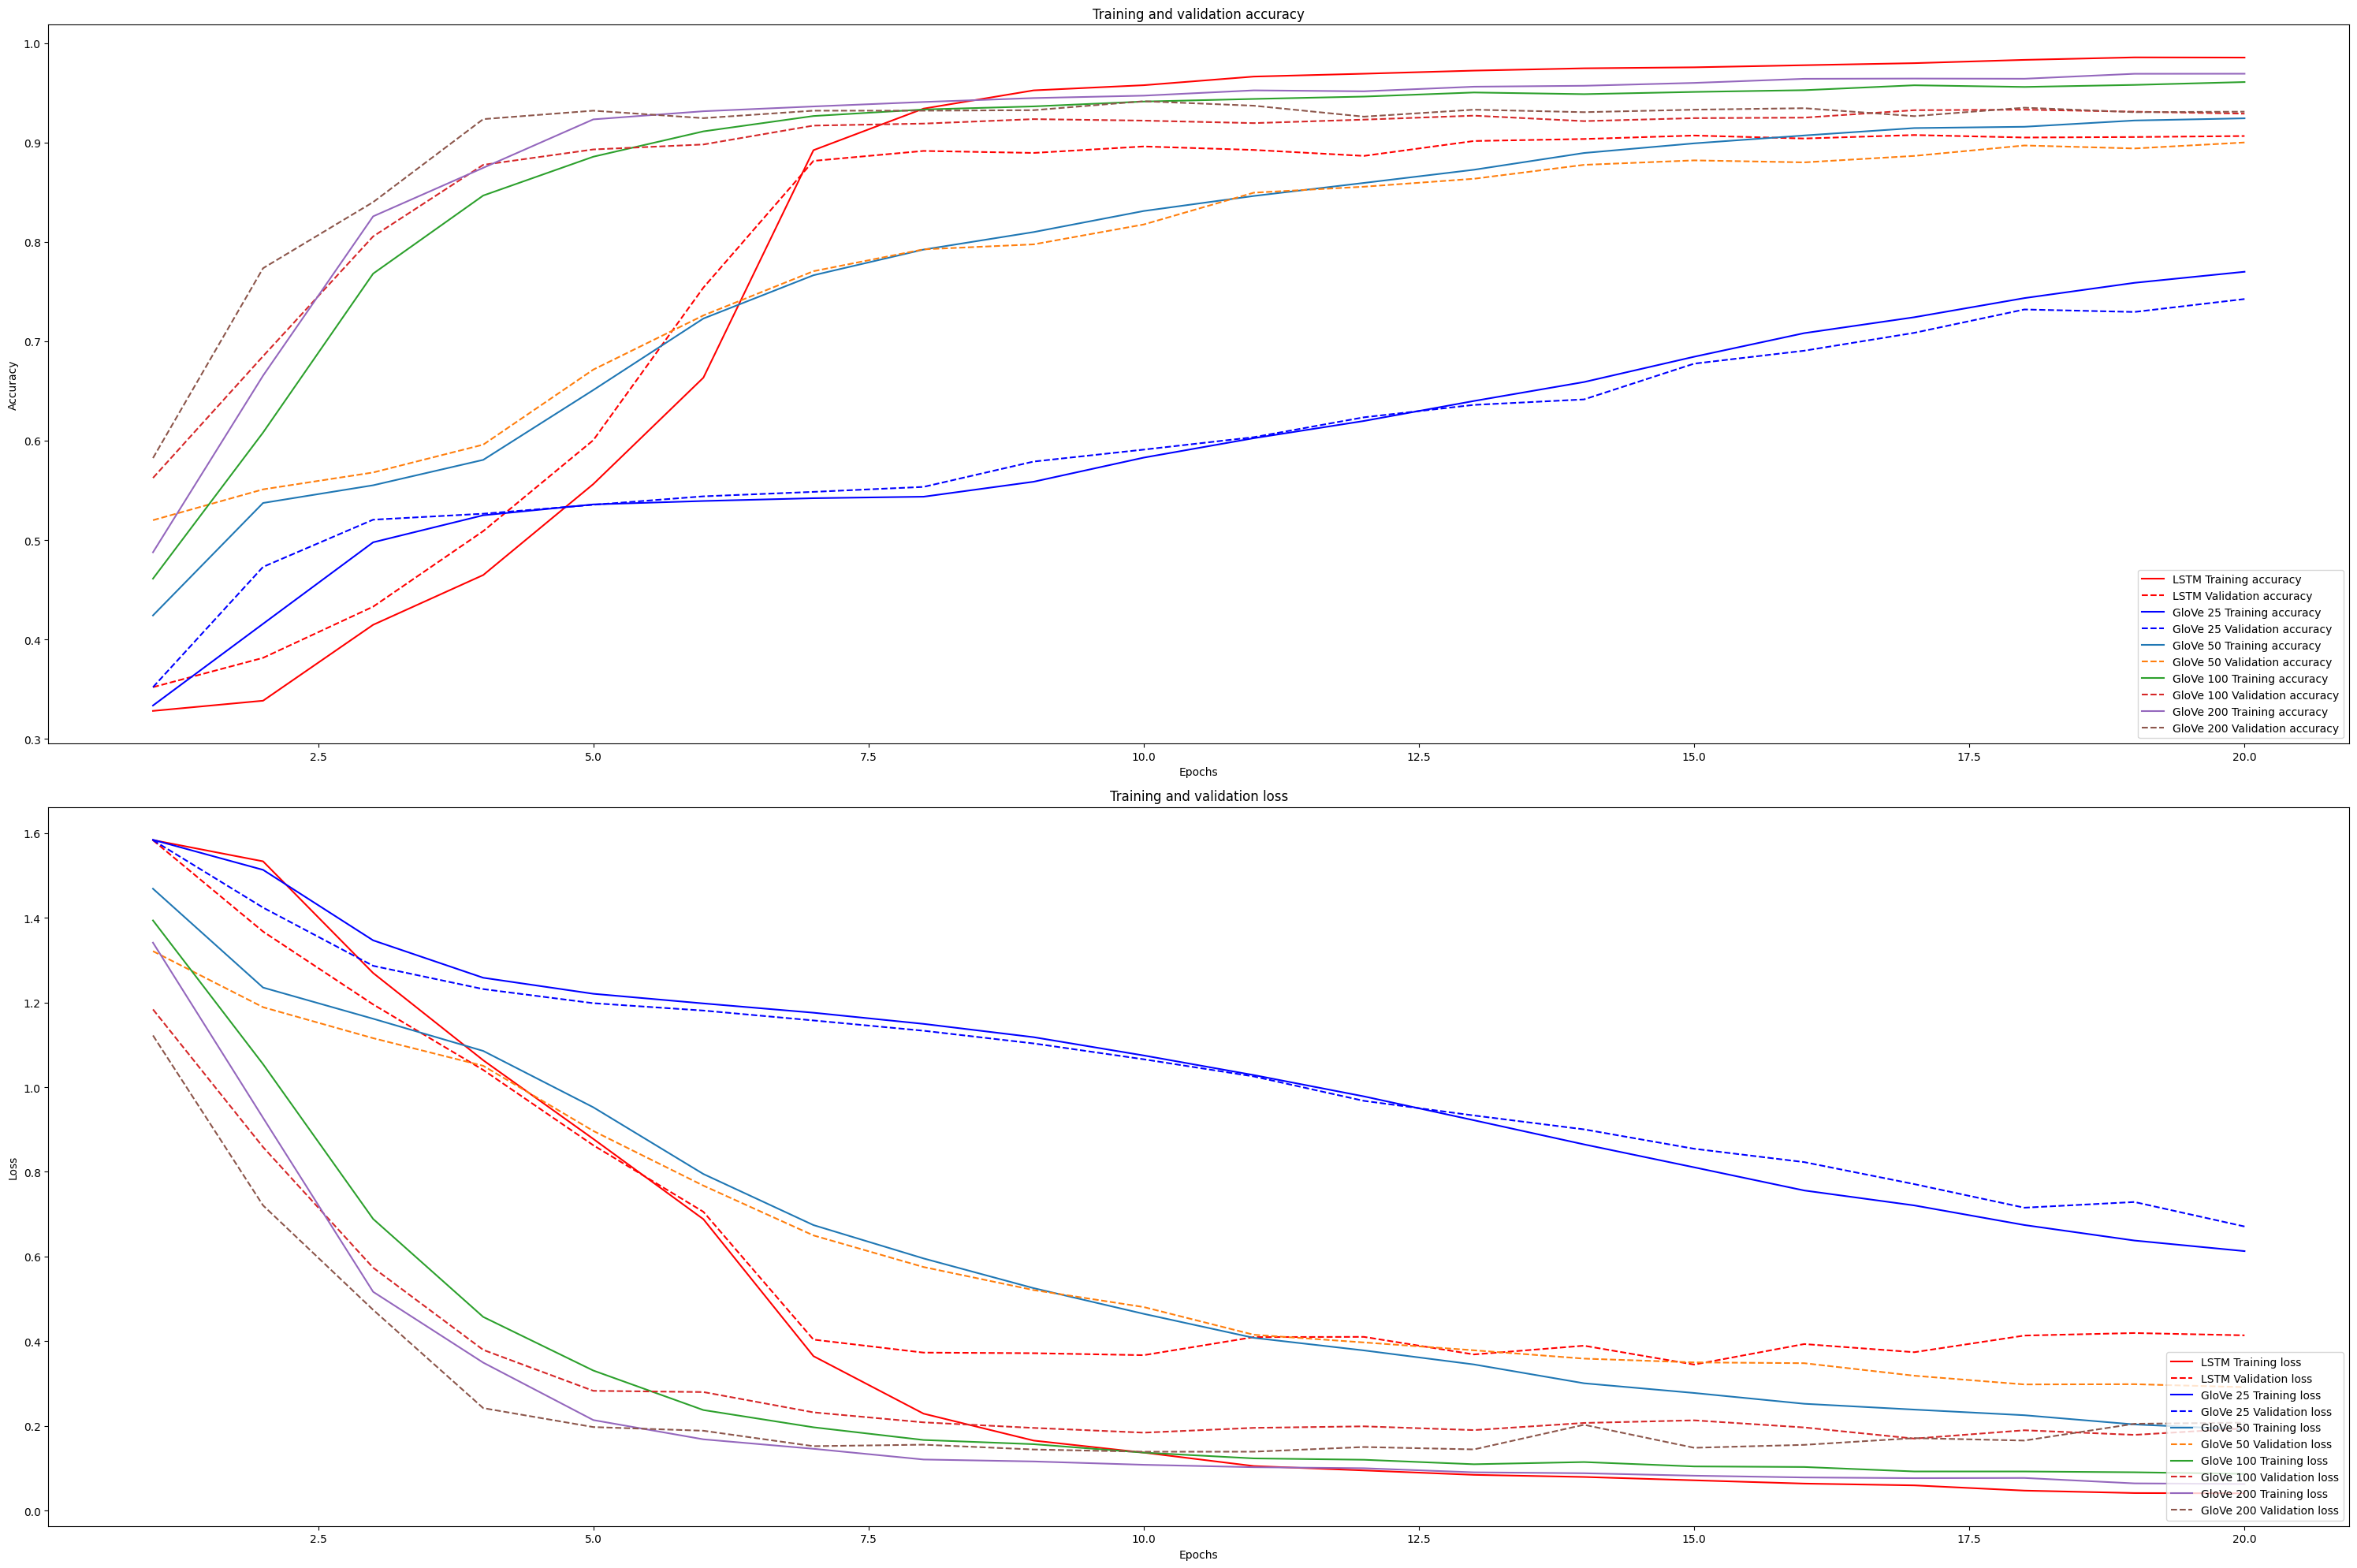

,Model,Accuracy,Loss
0,RNN,0.4965,1.657449
1,LSTM,0.9000,0.404295
2,glove-twitter-25,0.7460,0.680261
3,glove-twitter-50,0.8890,0.331010
4,glove-twitter-100,0.9215,0.226031
5,glove-twitter-200,0.9285,0.190562


In [48]:
epochs = range(1, len(history_lstm.history['accuracy']) + 1)

plt.figure(figsize=(30, 20))

plt.subplot(2, 1, 1)
plt.plot(epochs, history_lstm.history['accuracy'], 'r-', label='LSTM Training accuracy')
plt.plot(epochs, history_lstm.history['val_accuracy'], 'r--', label='LSTM Validation accuracy')
plt.plot(epochs, history_glove_25.history['accuracy'], 'b-', label='GloVe 25 Training accuracy')
plt.plot(epochs, history_glove_25.history['val_accuracy'], 'b--', label='GloVe 25 Validation accuracy')
plt.plot(epochs, history_glove_50.history['accuracy'], label='GloVe 50 Training accuracy')
plt.plot(epochs, history_glove_50.history['val_accuracy'], linestyle='dashed', label='GloVe 50 Validation accuracy')
plt.plot(epochs, history_glove_100.history['accuracy'], label='GloVe 100 Training accuracy')
plt.plot(epochs, history_glove_100.history['val_accuracy'], linestyle='dashed', label='GloVe 100 Validation accuracy')
plt.plot(epochs, history_glove_200.history['accuracy'], label='GloVe 200 Training accuracy')
plt.plot(epochs, history_glove_200.history['val_accuracy'], linestyle='dashed', label='GloVe 200 Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(epochs, history_lstm.history['loss'], 'r-', label='LSTM Training loss')
plt.plot(epochs, history_lstm.history['val_loss'], 'r--', label='LSTM Validation loss')
plt.plot(epochs, history_glove_25.history['loss'], 'b-', label='GloVe 25 Training loss')
plt.plot(epochs, history_glove_25.history['val_loss'], 'b--', label='GloVe 25 Validation loss')
plt.plot(epochs, history_glove_50.history['loss'], label='GloVe 50 Training loss')
plt.plot(epochs, history_glove_50.history['val_loss'], linestyle='dashed', label='GloVe 50 Validation loss')
plt.plot(epochs, history_glove_100.history['loss'], label='GloVe 100 Training loss')
plt.plot(epochs, history_glove_100.history['val_loss'], linestyle='dashed', label='GloVe 100 Validation loss')
plt.plot(epochs, history_glove_200.history['loss'], label='GloVe 200 Training loss')
plt.plot(epochs, history_glove_200.history['val_loss'], linestyle='dashed', label='GloVe 200 Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

display(df_performance)

Pretrained word embeddings are a type of word representation that allows words to be represented as continuous vectors in a high-dimensional space. These vectors capture semantic meanings and relationships between words based on their usage in large text corpora. Pretrained embeddings are typically generated by training on massive datasets, like the entire Wikipedia or a large collection of tweets, which helps in capturing rich linguistic patterns.

Using Embeddings acts as a form of transfer learning, a technique that wilded great results in the previous convolution assignment. By using embeddings, we are able to leverage the rich contextual information that was learned during the training of the embedding model, which helps the model gain semantic understanding and generalization capabilities (reducing overfitting).

Looking at the models we trained, the final results may seem to surprise us, since LSTM was able to achieve an accuracy matching the pretrained embeddings, even far surpassing the glove-twitter-25. However, the graph shows us that the pretrained embeddings are able to converge much faster. Since all models have the same architecture, it is safe to assume that all models would tend to eventually converge to similar accuracies, but the pretrained embeddings would do so much faster, which is a huge advantage in practice, since it reduces the computational cost and time needed to train the model.

## Question 3 (20 points)

Now load BERT models from TensorFlow Hub. Fine-tune it with the data and evaluate the model performance. Check how you can do it [here](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)

---
### Loading Models
Since there are plenty of models to choose from, we will select three models to compare their performance. Since our dataset is relatively small, and the data we are dealing with are just short sequences of text, we will give priority to less complex models, but still have variety in the models we test. With that we mind, we are testing the following models:

- small_bert/bert_en_uncased_L-6_H-512_A-8 
- albert_en_base
- bert_en_uncased_L-12_H-768_A-12/3 (this model is more complex, but it is interesting to compare with the other two)

In [5]:
bert_models = {'small_bert/bert_en_uncased_L-6_H-512_A-8':{}, 'albert_en_base':{}, 'bert_en_uncased_L-12_H-768_A-12': {}}

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

for model in bert_models.keys():
    bert_models[model]['handle'] = map_name_to_handle[model]
    bert_models[model]['preprocess'] = map_model_to_preprocess[model]
    print('*' * 100 + '\n' + model + ":\n")
    print(f'BERT model selected           : {map_name_to_handle[model]}')
    print(f'Preprocess model auto-selected: {map_model_to_preprocess[model]}')

****************************************************************************************************
small_bert/bert_en_uncased_L-6_H-512_A-8:

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
****************************************************************************************************
albert_en_base:

BERT model selected           : https://tfhub.dev/tensorflow/albert_en_base/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/albert_en_preprocess/3
****************************************************************************************************
bert_en_uncased_L-12_H-768_A-12:

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [6]:
# Since our text is preprocessed in a different way, we will need to convert the original hugging face dataset to the format that the BERT model expects
# Convert the hugging face datasets to tensorflow datasets and apply optimizations
batch_size = 32
sequence_length = 50

train_tf_ds_bert = tf.data.Dataset.from_generator(
        lambda: ((row['text'], row['label'] ) for row in emotion['train']),
        output_signature=(
            tf.TensorSpec(shape=(sequence_length,), dtype=tf.string),
            tf.TensorSpec(shape=(sequence_length, ), dtype=tf.int64)
        )
).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val_tf_ds_bert = tf.data.Dataset.from_generator(
        lambda: ((row['text'], row['label'] ) for row in emotion['validation']),
        output_signature=(
            tf.TensorSpec(shape=(sequence_length,), dtype=tf.string),
            tf.TensorSpec(shape=(sequence_length, ), dtype=tf.int64)
        )
).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_tf_ds_bert = tf.data.Dataset.from_generator(
        lambda: ((row['text'], row['label'] ) for row in emotion['test']),
        output_signature=(
            tf.TensorSpec(shape=(sequence_length,), dtype=tf.string),
            tf.TensorSpec(shape=(sequence_length, ), dtype=tf.int64)
        )
).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [7]:
def build_classifier_model(model_name):
  tfhub_handle_preprocess = bert_models[model_name]['preprocess']
  tfhub_handle_encoder = bert_models[model_name]['handle']

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(6, activation='softmax', name='classifier')(net)
  
  return tf.keras.Model(text_input, net)

In [9]:
# Define the models and copile them
epochs = 3
num_train_steps = len(emotion['train']) // batch_size
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
loss = 'sparse_categorical_crossentropy'
metrics = 'accuracy'

for model_name in bert_models.keys():
    model = build_classifier_model(model_name)
    model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
    bert_models[model_name]['model'] = model

2024-05-18 23:23:51.530424: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62509056 exceeds 10% of free system memory.
2024-05-18 23:24:06.932777: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15360000 exceeds 10% of free system memory.
2024-05-18 23:24:56.119413: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.


---
### Training

Due to model heaviness, I was not able to train the models. For context, the small_bert model would take 23 seconds per step, for 500 steps, for 3 epochs. This would mean that just for that one model, it would take approx. 9,5 hours to train, and this architecture is the simplest of the three. Using the TPU runtime from colab, I would be able to train each model in half an hour, but nowadays it is rare to have access to it. Still, I made sure that the code is correct, and given unlimited time or better resources, we would be able to compare the results.

#### small_bert/bert_en_uncased_L-6_H-512_A-8

In [ ]:
model_name = 'small_bert/bert_en_uncased_L-6_H-512_A-8'
bert_models[model_name]['history'] = bert_models[model_name]['model'].fit(x=train_tf_ds_bert,
                                                                              validation_data=val_tf_ds_bert,
                                                                              epochs=epochs)

In [ ]:
save_history(bert_models[model_name]['history'], 'small_bert')

loss, accuracy = model.evaluate(test_tf_ds_bert)
new_row = pd.DataFrame({'Model': [model_name], 'Accuracy': [accuracy], 'Loss': [loss]})
df_performance = pd.concat([df_performance, new_row], ignore_index=True)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [ ]:
acc = bert_models[model_name]['history'].history['accuracy']
val_acc = bert_models[model_name]['history'].history['val_accuracy']
loss = bert_models[model_name]['history'].history['loss']
val_loss = bert_models[model_name]['history'].history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

#### albert_en_base

In [ ]:
model_name = 'albert_en_base'
bert_models[model_name]['history'] = bert_models[model_name]['model'].fit(x=train_tf_ds_bert,
                                                                              validation_data=val_tf_ds_bert,
                                                                              epochs=epochs)

In [ ]:
save_history(bert_models[model_name]['history'], 'albert')

loss, accuracy = model.evaluate(test_tf_ds_bert)
new_row = pd.DataFrame({'Model': [model_name], 'Accuracy': [accuracy], 'Loss': [loss]})
df_performance = pd.concat([df_performance, new_row], ignore_index=True)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [ ]:
acc = bert_models[model_name]['history'].history['accuracy']
val_acc = bert_models[model_name]['history'].history['val_accuracy']
loss = bert_models[model_name]['history'].history['loss']
val_loss = bert_models[model_name]['history'].history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

#### bert_en_uncased_L-12_H-768_A-12

In [ ]:
model_name = 'bert_en_uncased_L-12_H-768_A-12'
bert_models[model_name]['history'] = bert_models[model_name]['model'].fit(x=train_tf_ds_bert,
                                                                              validation_data=val_tf_ds_bert,
                                                                              epochs=epochs)

In [ ]:
save_history(bert_models[model_name]['history'], 'uncased_bert')

loss, accuracy = model.evaluate(test_tf_ds_bert)
new_row = pd.DataFrame({'Model': [model_name], 'Accuracy': [accuracy], 'Loss': [loss]})
df_performance = pd.concat([df_performance, new_row], ignore_index=True)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [ ]:
acc = bert_models[model_name]['history'].history['accuracy']
val_acc = bert_models[model_name]['history'].history['val_accuracy']
loss = bert_models[model_name]['history'].history['loss']
val_loss = bert_models[model_name]['history'].history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

---
### Comparing Results

In [ ]:
# Bert Models
epochs_bert = range(1, 4)
epochs_rest = range(1, 21)
plt.figure(figsize=(20, 20))

plt.subplot(2, 1, 1)
plt.plot(epochs_bert, bert_models['small_bert/bert_en_uncased_L-6_H-512_A-8']['history'].history['accuracy'], 'r-', label='Small BERT Training accuracy')
plt.plot(epochs_bert, bert_models['small_bert/bert_en_uncased_L-6_H-512_A-8']['history'].history['val_accuracy'], 'r--', label='Small BERT Validation accuracy')
plt.plot(epochs_bert, bert_models['albert_en_base']['history'].history['accuracy'], label='ALBERT Training accuracy')
plt.plot(epochs_bert, bert_models['albert_en_base']['history'].history['val_accuracy'], linestyle='dashed', label='ALBERT Validation accuracy')
plt.plot(epochs_bert, bert_models['bert_en_uncased_L-12_H-768_A-12']['history'].history['accuracy'], label='BERT Uncased Training accuracy')
plt.plot(epochs_bert, bert_models['bert_en_uncased_L-12_H-768_A-12']['history'].history['val_accuracy'], linestyle='dashed', label='BERT Uncased Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(epochs_bert, bert_models['small_bert/bert_en_uncased_L-6_H-512_A-8']['history'].history['loss'], 'r-', label='Small BERT Training loss')
plt.plot(epochs_bert, bert_models['small_bert/bert_en_uncased_L-6_H-512_A-8']['history'].history['val_loss'], 'r--', label='Small BERT Validation loss')
plt.plot(epochs_bert, bert_models['albert_en_base']['history'].history['loss'], label='ALBERT Training loss')
plt.plot(epochs_bert, bert_models['albert_en_base']['history'].history['val_loss'], linestyle='dashed', label='ALBERT Validation loss')
plt.plot(epochs_bert, bert_models['bert_en_uncased_L-12_H-768_A-12']['history'].history['loss'], label='BERT Uncased Training loss')
plt.plot(epochs_bert, bert_models['bert_en_uncased_L-12_H-768_A-12']['history'].history['val_loss'], linestyle='dashed', label='BERT Uncased Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
# Best Bert with LSTM, RNN and best GloVe models

history_rnn = load_history('history_rnn')
history_lstm = load_history('history_lstm')
history_glove_200 = load_history('glove-twitter-200')

plt.figure(figsize=(30, 20))

plt.subplot(2, 1, 1)
plt.plot(epochs_bert, bert_models['small_bert/bert_en_uncased_L-6_H-512_A-8']['history'].history['accuracy'], 'r-', label='Small BERT Training accuracy')
plt.plot(epochs_bert, bert_models['small_bert/bert_en_uncased_L-6_H-512_A-8']['history'].history['val_accuracy'], 'r--', label='Small BERT Validation accuracy')
plt.plot(epochs_bert, bert_models['albert_en_base']['history'].history['accuracy'], 'b-', label='ALBERT Training accuracy')
plt.plot(epochs_bert, bert_models['albert_en_base']['history'].history['val_accuracy'], 'b--', linestyle='dashed', label='ALBERT Validation accuracy')
plt.plot(epochs_bert, bert_models['bert_en_uncased_L-12_H-768_A-12']['history'].history['accuracy'], label='BERT Uncased Training accuracy')
plt.plot(epochs_bert, bert_models['bert_en_uncased_L-12_H-768_A-12']['history'].history['val_accuracy'], linestyle='dashed', label='BERT Uncased Validation accuracy')
plt.plot(epochs_rest, history_rnn['accuracy'], label='RNN Training accuracy')
plt.plot(epochs_rest, history_rnn['val_accuracy'], label='RNN Validation accuracy')
plt.plot(epochs_rest, history_lstm['accuracy'], label='LSTM Training accuracy')
plt.plot(epochs_rest, history_lstm['val_accuracy'], label='LSTM Validation accuracy')
plt.plot(epochs_rest, history_glove_200['accuracy'], label='GloVe 200 Training accuracy')
plt.plot(epochs_rest, history_glove_200['val_accuracy'], label='GloVe 200 Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(epochs_bert, bert_models['small_bert/bert_en_uncased_L-6_H-512_A-8']['history'].history['loss'], 'r-', label='Small BERT Training loss')
plt.plot(epochs_bert, bert_models['small_bert/bert_en_uncased_L-6_H-512_A-8']['history'].history['val_loss'], 'r--', label='Small BERT Validation loss')
plt.plot(epochs_bert, bert_models['albert_en_base']['history'].history['loss'], 'b-', label='ALBERT Training loss')
plt.plot(epochs_bert, bert_models['albert_en_base']['history'].history['val_loss'], 'b--', linestyle='dashed', label='ALBERT Validation loss')
plt.plot(epochs_bert, bert_models['bert_en_uncased_L-12_H-768_A-12']['history'].history['loss'], label='BERT Uncased Training loss')
plt.plot(epochs_bert, bert_models['bert_en_uncased_L-12_H-768_A-12']['history'].history['val_loss'], linestyle='dashed', label='BERT Uncased Validation loss')
plt.plot(epochs_rest, history_rnn['loss'], label='RNN Training accuracy')
plt.plot(epochs_rest, history_rnn['val_loss'], label='RNN Validation accuracy')
plt.plot(epochs_rest, history_lstm['loss'], label='LSTM Training accuracy')
plt.plot(epochs_rest, history_lstm['val_loss'], label='LSTM Validation accuracy')
plt.plot(epochs_rest, history_glove_200['loss'], label='GloVe 200 Training accuracy')
plt.plot(epochs_rest, history_glove_200['val_loss'], label='GloVe 200 Validation accuracy')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

display(df_performance)

# Question 4 (10 points)

Now let's try some state-of-the-art Large Language Models (LLM)! Cohere provides trial API for free and you may register and use the LLM. After you obtain the trial API, go to https://dashboard.cohere.com/playground/classify and see how the LLM-based classification works. You could choose several pretrained embedding models such as embed-engligh-2.0 or embed-engligh-3.0 and provide example training data. Evaluate the model performance.

We will test three different embedding models. Note that in our code, we cannot use more htan 96 text sequences in our request, so we will use 80 in the training items and 16 in test items. Since the training data is really small, we won't compare the results with the previous models, but we will instead just compare between the Cohere models.

In [75]:
df_cohere = pd.DataFrame(index=['embed-english-v3.0', 'embed-english-v2.0', 'embed-english-light-v3.0'],
                         columns=['Accuracy'])

---
### embed-english-v3.0

In [99]:
COHERE_API_KEY = os.getenv('COHERE_API_KEY')
co = cohere.Client(COHERE_API_KEY)

def create_example(item):
    text = item['text']
    label = item['label']
    return cohere.ClassifyExample(text=text, label=label)

indices_examples = np.random.choice(len(emotion['train']), 80)
examples = [create_example(item) for item in emotion['train'].select(list(indices_examples))]

indices_inputs = np.random.choice(len(emotion['test']), 16)
inputs = [item['text'] for item in emotion['test'].select(list(indices_inputs))]

response = co.classify(
    model='embed-english-v3.0',
    inputs=inputs,
    examples=examples,
)
display(response)

ClassifyResponse(id='23b107db-64ec-4e8f-8d0a-ba248b1bf5bd', classifications=[ClassifyResponseClassificationsItem(id='ad95534d-eca0-40d2-8306-18269d037c3e', input='i always said i felt so blessed to have him and today that feeling is been reassured many times', prediction='1', predictions=['1'], confidence=0.48292693, confidences=[0.48292693], labels={'0': ClassifyResponseClassificationsItemLabelsValue(confidence=0.1513834), '1': ClassifyResponseClassificationsItemLabelsValue(confidence=0.48292693), '2': ClassifyResponseClassificationsItemLabelsValue(confidence=0.16174345), '3': ClassifyResponseClassificationsItemLabelsValue(confidence=0.08818756), '4': ClassifyResponseClassificationsItemLabelsValue(confidence=0.07968613), '5': ClassifyResponseClassificationsItemLabelsValue(confidence=0.03607252)}, classification_type='single-label'), ClassifyResponseClassificationsItem(id='aab6cbc6-40dc-4995-9b4e-5d575ebe98e6', input='i feel like i m the one being punished', prediction='0', predictions

In [86]:
df_embed_english_v3 = pd.DataFrame(response.classifications)
df_embed_english_v3.drop(columns=[0, 3, 5, 6, 7], inplace=True)
df_embed_english_v3.rename(columns={1: 'Text', 2: 'Prediction', 4: 'Confidence'}, inplace=True)
df_embed_english_v3['Text'] = df_embed_english_v3['Text'].map(lambda x: x[1])
df_embed_english_v3['Prediction'] = df_embed_english_v3['Prediction'].map(lambda x: x[1])
df_embed_english_v3['Confidence'] = df_embed_english_v3['Confidence'].map(lambda x: x[1])

true_lables = pd.DataFrame(columns=['Text', 'Actual Label'])
for item in emotion['test'].select(list(indices_inputs)):
    row = pd.DataFrame({'Text': [item['text']], 'Actual Label': [item['label']]})
    true_lables = pd.concat([true_lables, row], ignore_index=True)

df_embed_english_v3 = pd.merge(df_embed_english_v3, true_lables, on='Text')
df_embed_english_v3['Actual Label'] = df_embed_english_v3['Actual Label'].astype(int)
df_embed_english_v3['Prediction'] = df_embed_english_v3['Prediction'].astype(int)

accuracy = df_embed_english_v3[df_embed_english_v3['Prediction'] == df_embed_english_v3['Actual Label']].shape[0] / df_embed_english_v3.shape[0]
df_cohere.loc['embed-english-v3.0'] = accuracy
print("Accuracy: ", str(accuracy*100) + "%")
display(df_embed_english_v3)

Accuracy:  62.5%


,Text,Prediction,Confidence,Actual Label
0,ive been feeling incredibly inadequate more so...,0,0.449486,0
1,i mean is that when we are true to ourselves a...,1,0.419415,0
2,i love doing yoga i love learning about it i l...,1,0.527724,1
3,i feel numb as i carry on and i wonder if i wi...,0,0.441589,0
4,i feel relatively safe normal or whatever you ...,1,0.466010,1
5,ive missed that feeling and ive missed being t...,0,0.270000,0
6,i feel immensely distracted by the barrage of ...,0,0.354893,3
7,i feel convinced that im going to shy away fro...,0,0.345963,1
8,i am feeling content and happy with myself,1,0.597497,1
9,i find myself feeling anxious and unsure,4,0.365870,4


#### embed-english-v2.0	

In [89]:
co = cohere.Client(COHERE_API_KEY)

response = co.classify(
    model='embed-english-v2.0',
    inputs=inputs,
    examples=examples,
)
display(response)

ClassifyResponse(id='d4a7dd1c-d84e-4d29-90d1-fb09edc7ba21', classifications=[ClassifyResponseClassificationsItem(id='08d839ec-eacf-4751-b433-355d5cc9f72f', input='ive been feeling incredibly inadequate more so than usual and its gotten to a point where i almost feel paralyzed by it', prediction='0', predictions=['0'], confidence=0.97125703, confidences=[0.97125703], labels={'0': ClassifyResponseClassificationsItemLabelsValue(confidence=0.97125703), '1': ClassifyResponseClassificationsItemLabelsValue(confidence=0.0001451258), '2': ClassifyResponseClassificationsItemLabelsValue(confidence=1.5104485e-05), '3': ClassifyResponseClassificationsItemLabelsValue(confidence=0.0009325577), '4': ClassifyResponseClassificationsItemLabelsValue(confidence=0.027062165), '5': ClassifyResponseClassificationsItemLabelsValue(confidence=0.0005880016)}, classification_type='single-label'), ClassifyResponseClassificationsItem(id='0f080507-a412-40fb-a280-07968e799e7b', input='i mean is that when we are true t

In [90]:
df_embed_english_v2 = pd.DataFrame(response.classifications)
df_embed_english_v2.drop(columns=[0, 3, 5, 6, 7], inplace=True)
df_embed_english_v2.rename(columns={1: 'Text', 2: 'Prediction', 4: 'Confidence'}, inplace=True)
df_embed_english_v2['Text'] = df_embed_english_v2['Text'].map(lambda x: x[1])
df_embed_english_v2['Prediction'] = df_embed_english_v2['Prediction'].map(lambda x: x[1])
df_embed_english_v2['Confidence'] = df_embed_english_v2['Confidence'].map(lambda x: x[1])

true_lables = pd.DataFrame(columns=['Text', 'Actual Label'])
for item in emotion['test'].select(list(indices_inputs)):
    row = pd.DataFrame({'Text': [item['text']], 'Actual Label': [item['label']]})
    true_lables = pd.concat([true_lables, row], ignore_index=True)

df_embed_english_v2 = pd.merge(df_embed_english_v2, true_lables, on='Text')
df_embed_english_v2['Actual Label'] = df_embed_english_v2['Actual Label'].astype(int)
df_embed_english_v2['Prediction'] = df_embed_english_v2['Prediction'].astype(int)

accuracy = df_embed_english_v2[df_embed_english_v2['Prediction'] == df_embed_english_v2['Actual Label']].shape[0] / df_embed_english_v2.shape[0]
df_cohere.loc['embed-english-v2.0'] = accuracy
print("Accuracy: ", str(accuracy*100) + "%")
display(df_embed_english_v2)

Accuracy:  62.5%


,Text,Prediction,Confidence,Actual Label
0,ive been feeling incredibly inadequate more so...,0,0.971257,0
1,i mean is that when we are true to ourselves a...,0,0.975014,0
2,i love doing yoga i love learning about it i l...,1,0.998758,1
3,i feel numb as i carry on and i wonder if i wi...,0,0.608736,0
4,i feel relatively safe normal or whatever you ...,1,0.956523,1
5,ive missed that feeling and ive missed being t...,4,0.382693,0
6,i feel immensely distracted by the barrage of ...,0,0.916880,3
7,i feel convinced that im going to shy away fro...,1,0.806930,1
8,i am feeling content and happy with myself,1,0.999862,1
9,i find myself feeling anxious and unsure,4,0.998234,4


#### embed-english-light-v3.0	

In [93]:
co = cohere.Client(COHERE_API_KEY)

response = co.classify(
    model='embed-english-light-v3.0',
    inputs=inputs,
    examples=examples,
)
display(response)

ClassifyResponse(id='e793c1f3-f65c-421f-8db7-ba1150c917a7', classifications=[ClassifyResponseClassificationsItem(id='8b73e9e0-6e4b-447a-8d68-49a06f7a2732', input='ive been feeling incredibly inadequate more so than usual and its gotten to a point where i almost feel paralyzed by it', prediction='0', predictions=['0'], confidence=0.4994056, confidences=[0.4994056], labels={'0': ClassifyResponseClassificationsItemLabelsValue(confidence=0.4994056), '1': ClassifyResponseClassificationsItemLabelsValue(confidence=0.09536236), '2': ClassifyResponseClassificationsItemLabelsValue(confidence=0.03717404), '3': ClassifyResponseClassificationsItemLabelsValue(confidence=0.14455393), '4': ClassifyResponseClassificationsItemLabelsValue(confidence=0.18841954), '5': ClassifyResponseClassificationsItemLabelsValue(confidence=0.03508456)}, classification_type='single-label'), ClassifyResponseClassificationsItem(id='2cbaadbc-ed3d-4825-b1b5-a00bf534a2c8', input='i mean is that when we are true to ourselves a

In [94]:
df_embed_english_light_v3 = pd.DataFrame(response.classifications)
df_embed_english_light_v3.drop(columns=[0, 3, 5, 6, 7], inplace=True)
df_embed_english_light_v3.rename(columns={1: 'Text', 2: 'Prediction', 4: 'Confidence'}, inplace=True)
df_embed_english_light_v3['Text'] = df_embed_english_light_v3['Text'].map(lambda x: x[1])
df_embed_english_light_v3['Prediction'] = df_embed_english_light_v3['Prediction'].map(lambda x: x[1])
df_embed_english_light_v3['Confidence'] = df_embed_english_light_v3['Confidence'].map(lambda x: x[1])

true_lables = pd.DataFrame(columns=['Text', 'Actual Label'])
for item in emotion['test'].select(list(indices_inputs)):
    row = pd.DataFrame({'Text': [item['text']], 'Actual Label': [item['label']]})
    true_lables = pd.concat([true_lables, row], ignore_index=True)

df_embed_english_light_v3 = pd.merge(df_embed_english_light_v3, true_lables, on='Text')
df_embed_english_light_v3['Actual Label'] = df_embed_english_light_v3['Actual Label'].astype(int)
df_embed_english_light_v3['Prediction'] = df_embed_english_light_v3['Prediction'].astype(int)

accuracy = df_embed_english_v2[df_embed_english_v2['Prediction'] == df_embed_english_light_v3['Actual Label']].shape[0] / df_embed_english_light_v3.shape[0]
df_cohere.loc['embed-english-light-v3.0'] = accuracy
print("Accuracy: ", str(accuracy*100) + "%")
display(df_embed_english_light_v3)

Accuracy:  62.5%


,Text,Prediction,Confidence,Actual Label
0,ive been feeling incredibly inadequate more so...,0,0.499406,0
1,i mean is that when we are true to ourselves a...,0,0.374912,0
2,i love doing yoga i love learning about it i l...,1,0.637320,1
3,i feel numb as i carry on and i wonder if i wi...,0,0.364616,0
4,i feel relatively safe normal or whatever you ...,1,0.489914,1
5,ive missed that feeling and ive missed being t...,1,0.260130,0
6,i feel immensely distracted by the barrage of ...,0,0.347429,3
7,i feel convinced that im going to shy away fro...,1,0.272252,1
8,i am feeling content and happy with myself,1,0.693448,1
9,i find myself feeling anxious and unsure,4,0.317580,4


#### Comparing Results

In [95]:
display(df_cohere)

,Accuracy
embed-english-v3.0,0.625
embed-english-v2.0,0.625
embed-english-light-v3.0,0.625


Comparing the models, we can observe that for the small dataset we tested for, there is exactly no difference in classification. This is likely due to the small dataset, as it would be expected the models to diverge depending on size and type of data, since they are built different. But, for our problem specifically, we can infer (with a grain of salt) that the models are fairly equivalent in performance.

Relatively to the previous models tested before, these classifiers are inferior, as it has only an accuracy of 62.5%.